![image](https://nfldraftdiamonds.com/wp-content/uploads/2023/03/Football-Analytics-Graphic-Header-scaled.jpg)

# The NFL Ground Game: 
# Analyzing the Impact of Playing Surfaces & Player Safety

## Introduction  
In this notebook, we dive into the challenge of understanding how playing surfaces—namely synthetic turf versus natural turf—affect NFL players' movement, performance, and injury risk. This investigation is part of the broader NFL 1st & Future Kaggle analytics competition, designed to spur innovation in player health, safety, and performance.

## Background
The NFL currently has 12 stadiums with synthetic turf fields. Recent investigations have highlighted differences in injury rates between synthetic and natural playing surfaces. Biomechanical studies of football cleat-surface interactions suggest that synthetic turf surfaces may not release cleats as readily as natural turf, potentially contributing to non-contact lower limb injuries. The NFL has provided a unique dataset derived from Next Gen Stats: full player tracking of 250 athletes over two regular season schedules. The data will show 100 athletes sustained non-contact lower limb injuries, while the remaining 150 serve as a representative sample of the NFL population without such injuries.

## The Challenge
The primary objectives of this analysis are to:

Examine Player Movement: Characterize differences in player movements (e.g., speed, direction changes, and acceleration) across different playing surfaces.

Identify Risk Scenarios: Investigate situational variables—including field surface, stadium types,  weather conditions, player position, and play type—that may influence the incidence of lower limb injuries.

Uncover Performance Insights: Understand how variations in playing surface affect overall player performance, with the goal of enhancing player safety without compromising on-field effectiveness.

## Problem Statement
 Analyze two seasons of NFL player tracking and injury data to compare the frequency of lower-extremity injuries on synthetic versus natural playing surfaces using statistical tests to establish significance and provide actionable recommendations for training adjustments and field maintenance practices, with the objective of reducing injury incidence by the upcoming season.

In [1]:
import os  
import csv  
import json  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import seaborn as sns  
from tqdm import tqdm
import io

DATA_PATH = '../data/'

print(os.listdir(DATA_PATH))

['InjuryRecord.csv', 'inj_playlist.csv', 'PlayerTrackData.csv', 'PlayList.csv']


### Preparing the Data: Helper Functions
Lets set up several helper functions to streamline our workflow and optimize memory usage. In this section, we define functions that will help us:

- Reduce Memory Usage:
Large datasets can quickly consume available RAM. The reduce_mem_usage function scans through all columns in a DataFrame and converts them to more memory-efficient data types where possible (e.g., from default integer types to int8, int16, or from float defaults to float16). This step is crucial for working with a massive dataset like the player tracking data.

- Import Data Efficiently:
The import_data function is designed to load a CSV file into a Pandas DataFrame while automatically invoking the memory reduction function. This lets us work with the data without having to worry about high memory consumption.

- Quick DataFrame Insights:
In order to understand the shape, types, and basic statistics of our dataset quickly, the get_df_info function is provided. It displays sample rows and summarizes key information such as column names, data types, and missing values. This helps us verify that our data is loaded correctly and is ready for analysis.

- Plot Football Field: 
A helper function for plotting a football field was created to visually represent the football field layout for our analysis. 

In [2]:
# Helper Functions
# This function iterates over each column of the DataFrame, checking the minimum and maximum values, and downcasts the numeric types. For object types, it converts them to 'category'.
def reduce_mem_usage(df):  
    start_mem = df.memory_usage().sum() / 1024**2  
    for col in df.columns:  
        col_type = df[col].dtype  
        if col_type != object:  
            c_min = df[col].min()  
            c_max = df[col].max()  
            if str(col_type)[:3] == "int":  
                original_type = col_type  
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:  
                    df[col] = df[col].astype(np.int8)  
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:  
                    df[col] = df[col].astype(np.int16)  
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:  
                    df[col] = df[col].astype(np.int32)  
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:  
                    df[col] = df[col].astype(np.int64)  
                if df[col].dtype != original_type:  
                    print("Converted", col, "from", original_type, "to", df[col].dtype)  
            else:  
                original_type = col_type  
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:  
                    df[col] = df[col].astype(np.float16)  
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:  
                    df[col] = df[col].astype(np.float32)  
                else:  
                    df[col] = df[col].astype(np.float64)  
                if df[col].dtype != original_type:  
                    print("Converted", col, "from", original_type, "to", df[col].dtype)  
        else:  
            original_type = col_type  
            df[col] = df[col].astype('category')  
            print("Converted", col, "from", original_type, "to", df[col].dtype)
    return df  

# This function first checks the file size. If the file size is greater than the threshold_mb value, it reads the file in chunks using the provided chunksize and applies reduce_mem_usage on each chunk. Finally, it concatenates the processed chunks. If the file is smaller, it reads the entire file at once and then optimizes it.
def import_data(file_path, threshold_mb=500, chunksize=1000000):
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)  
    print('\n' + '='*70)  
    print("Processing file:", os.path.basename(file_path), "({:.2f} MB)".format(file_size_mb))  
    print('='*70 + '\n')  
    try:  
        if file_size_mb > threshold_mb:  
            print("Large file detected. Loading in chunks (chunk size =", chunksize, "rows).")  
            chunks = []  
            for chunk_no, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize, parse_dates=True, keep_date_col=True)):  
                print("Processing chunk", chunk_no + 1)  
                chunk = reduce_mem_usage(chunk)  
                chunks.append(chunk)  
            df = pd.concat(chunks, ignore_index=True)  
            print("All chunks processed and combined.")  
        else:  
            print("Loading file in single pass.")  
            df = pd.read_csv(file_path, parse_dates=True, keep_date_col=True)  
            df = reduce_mem_usage(df)  
        print("Final DataFrame shape:", df.shape) 
        end_mem = df.memory_usage().sum() / 1024**2  
        print("Final Memory Usage: {:.2f} MB".format(end_mem))  
        return df  
    except Exception as e:  
        print("Error processing file", file_path, ":", str(e))  
        return None  

# Get dataframe info like columns, missing values, data type, etc.
def get_df_info(df):
    display(df.head(3).style.hide(axis='index')
            .set_properties(**{'text-align': 'center'}))
    buf = io.StringIO()
    df.info(buf=buf)
    info = buf.getvalue().split('\n')[-2]
    df_samples = pd.DataFrame({'Number of Samples': df.shape[0], 
                        'Number of Features' : df.shape[1]},
                        index=[0])
    display(df_samples.style.hide(axis='index')
            .set_properties(**{'text-align': 'center'}))
    df_types = df.dtypes
    df_types = pd.DataFrame({'Column':df_types.index, 'Type':df_types.values})
    display(df_types.style.hide(axis='index')
            .set_properties(**{'text-align': 'center'})) 
    missing = df.isnull().sum().sort_values(ascending=False)
    if missing.values.sum() == 0:
        missing = pd.DataFrame({'Missing Values' : "No Missing Values"})
    else:
        missing = missing[missing > 0]
        missing = pd.DataFrame({'Feature' : missing.index, 'Missing Values' : missing.values})
        display(missing.style.hide(axis='index')
                .set_properties(**{'text-align': 'center'}))


# Plot the Football Field for viewing plays
# Source: https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
def create_football_field(linenumbers=True,
                endzones=True,
                highlight_line=False,
                highlight_line_number=50,
                highlighted_name='Line of Scrimmage',
                fifty_is_los=False,
                figsize=(12, 6.33)):
    
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
            edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
            80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
            53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                    horizontalalignment='center',
                    fontsize=20,  # fontname='Arial',
                    color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                    horizontalalignment='center',
                    fontsize=20,  # fontname='Arial',
                    color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                color='yellow')
    return fig, ax

## Basic Data Information

 This project leverages three key datasets in CSV format:  
- **InjuryRecord.csv**: A focused dataset containing 105 lower extremity injury cases, detailing injury specifics and surface types over two seasons.  
- **PlayList.csv**: Records of 267,005 plays including player’s assigned roster position, stadium type, field type, weather, play type, position for the play, and position group. Each play is indexed by PlayerKey, GameID, and PlayKey fields.
- **PlayerTrackData.csv**: Over 76 million rows of detailed NFL player movement data that describes the location, orientation, speed, and direction of each player during a play recorded at 10 Hz.   

**Table 1 - File Variables**
   
|File   |Variable |
|---|---|
| Injury Record  | `injury_record`|
|  Play List | `play_list`|
|  Player Track Data | `player_track`|<br>

Now, lets use our helper functions to load the data, reduce memory usage, and check out the basic data information!

In [3]:
# For cross-platform compatibility we will use os.path.join() to automatically use the correct seperator for the current operating system.
file_paths = {  
    'injury': os.path.join(DATA_PATH, "InjuryRecord.csv"),  
    'plays': os.path.join(DATA_PATH, "PlayList.csv"),  
    'tracking': os.path.join(DATA_PATH, "PlayerTrackData.csv")  
}  

injury_record = import_data(file_paths['injury'])
play_list = import_data(file_paths['plays'])
player_track = import_data(file_paths['tracking'])


Processing file: InjuryRecord.csv (0.00 MB)

Loading file in single pass.
Converted PlayerKey from int64 to int32
Converted GameID from object to category
Converted PlayKey from object to category
Converted BodyPart from object to category
Converted Surface from object to category
Converted DM_M1 from int64 to int8
Converted DM_M7 from int64 to int8
Converted DM_M28 from int64 to int8
Converted DM_M42 from int64 to int8
Final DataFrame shape: (105, 9)
Final Memory Usage: 0.01 MB

Processing file: PlayList.csv (22.99 MB)

Loading file in single pass.
Converted PlayerKey from int64 to int32
Converted GameID from object to category
Converted PlayKey from object to category
Converted RosterPosition from object to category
Converted PlayerDay from int64 to int16
Converted PlayerGame from int64 to int8
Converted StadiumType from object to category
Converted FieldType from object to category
Converted Temperature from int64 to int16
Converted Weather from object to category
Converted PlayTyp

In [4]:
def display_all_datasets_info(datasets_dict):  
    for name, df in datasets_dict.items():  
        print('\n' + '='*70)  
        print(f'{name.upper()} DATASET OVERVIEW')  
        print('='*70 + '\n')  
        # Use the get_df_info helper function  
        get_df_info(df)  
        # Add memory usage information  
        print(f"\nMemory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")  
        print('\n' + '-'*70)  

# Create dictionary of datasets  
datasets = {  
    'Injury Record': injury_record,  
    'Play List': play_list,  
    'Player Tracking': player_track  
}  

# Display information for all datasets  
display_all_datasets_info(datasets)  


INJURY RECORD DATASET OVERVIEW



PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1


Number of Samples,Number of Features
105,9


Column,Type
PlayerKey,int32
GameID,category
PlayKey,category
BodyPart,category
Surface,category
DM_M1,int8
DM_M7,int8
DM_M28,int8
DM_M42,int8


Feature,Missing Values
PlayKey,28



Memory Usage: 0.01 MB

----------------------------------------------------------------------

PLAY LIST DATASET OVERVIEW



PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB


Number of Samples,Number of Features
267005,14


Column,Type
PlayerKey,int32
GameID,category
PlayKey,category
RosterPosition,category
PlayerDay,int16
PlayerGame,int8
StadiumType,category
FieldType,category
Temperature,int16
Weather,category


Feature,Missing Values
Weather,18691
StadiumType,16910
PlayType,367



Memory Usage: 16.13 MB

----------------------------------------------------------------------

PLAYER TRACKING DATASET OVERVIEW



PlayKey,time,event,x,y,dir,dis,o,s
26624-1-1,0.000000,huddle_start_offense,87.437500,28.937500,288.250000,0.010002,262.250000,0.130005
26624-1-1,0.099976,nan,87.437500,28.921875,284.000000,0.010002,261.750000,0.119995
26624-1-1,0.199951,nan,87.437500,28.921875,280.500000,0.010002,261.250000,0.119995


Number of Samples,Number of Features
76366748,9


Column,Type
PlayKey,object
time,float16
event,object
x,float16
y,float16
dir,float16
dis,float16
o,float16
s,float16


Feature,Missing Values
event,74526875
dir,2
o,2



Memory Usage: 2184.87 MB

----------------------------------------------------------------------


## Dataset Overview and Challenges:

1. Injury Records Dataset
- Small dataset with only 105 records
- Contains 28 missing values (roughly 30% of data)
- Critical for injury analysis despite its small size
- Uses one-hot encoding for "Days Missed" (columns DM_M1 through DM_M42)
- Need to convert these back to simple integer values for analysis
- Key focus: Reconstruct the PlayKey to join with other datasets

2. Play List Dataset
- Moderate-sized dataset: 267,005 records with 14 features
- Rich source of information about how injuries occurred
- Has some missing values in weather, stadiumtype, and playtype but they're manageable
- The StadiumType and Weather features require corrections due to inconsistent labeling to ensure consistency and accuracy.

3. Player Tracking Dataset
- Massive dataset: 76.3M records with 9 features
- Contains player movement data (coordinates, speed, timing)
- Minor missing values in 'o' and 'dir' columns (can be dropped)
- Significant missing data in 'event' column (74.5M missing values)
- Need to investigate 'event' column during analysis

### Next Steps:

- Before reconstructing the PlayKey lets combine the days missed columns and clean the stadium type and weather columns with consistent labeling in preparation for our join. 

- Our next priority is understanding and reconstructing the PlayKey field, which will help link these datasets together coherently. This will create a foundation for cleaning and analyzing the data effectively.

In [5]:
print(injury_record.columns)

# Display unique values in StadiumType and Weather columns with their counts  
print("Stadium Types and their frequencies:")  
print(play_list['StadiumType'].value_counts().to_frame())  

print("\n" + "="*50 + "\n")  

print("Weather conditions and their frequencies:")  
print(play_list['Weather'].value_counts().to_frame())  

Index(['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1',
       'DM_M7', 'DM_M28', 'DM_M42'],
      dtype='object')
Stadium Types and their frequencies:
                         count
StadiumType                   
Outdoor                 145032
Outdoors                 32956
Indoors                  22805
Dome                      9376
Retractable Roof          8914
Indoor                    6892
Open                      4124
Domed, closed             3076
Retr. Roof - Closed       2235
Retr. Roof-Closed         2015
Domed, open               1779
Dome, closed              1059
Closed Dome               1011
Domed                      985
Oudoor                     914
Domed, Open                807
Ourdoor                    778
Outdoor Retr Roof-Open     601
Outddors                   595
Indoor, Roof Closed        547
Retr. Roof-Open            486
Retr. Roof - Open          486
Indoor, Open Roof          479
Bowl                       465
Retr. Roof Closed        

In [6]:
# Clean Data
# Revert Days Missed 
days_missed_dict = {1 : "1+", 2: "7+", 3 : "28+", 4 : "42+"}

# StadiumType corrections
stadium_dict = {"Oudoor" : "Outdoor", "Outdoors" : "Outdoor", "Outdor" : "Outdoor", "Ourdoor" : "Outdoor", 
                "Outdoor Retr Roof-Open" : "Retractable Roof", "Open" : "Outdoor", 'Outdoor Retr Roof-Open' : "Retractable Roof",
                "Outddors" : "Outdoor", 'Retr. Roof-Open' : "Retractable Roof",  "Indoor, Open Roof" : "Indoor", "Heinz Field" : "Outdoor",
                "Domed, Open" : "Dome", "Domed, open" : "Dome", 'Retr. Roof - Open' : "Retractable Roof", "Outside" : "Outdoor",
                "Closed Dome" : "Dome", "Domed, closed" : "Dome", "Dome" : "Dome", "Domed" : "Dome", 
                "Indoors" : "Indoor", 'Retr. Roof-Closed' : "Retractable Roof", "Retractable Roof" : "Retractable Roof",  'Indoor, Roof Closed' : "Indoor",
                "Retr. Roof - Closed" : "Retractable Roof", 'Dome, closed' : "Dome", "Retr. Roof Closed" : "Retractable Roof", "Bowl" : np.NaN, "nan" : np.NaN, 'Cloudy' : np.NaN}

# Weather corrections
weather_dict = {"Indoors" : "Indoor", "N/A (Indoors)": "Indoor", "Clear skies" : "Clear", "Clear Skies" : "Clear",
                "Clear and cold" : "Clear", 'Cloudy, light snow accumulating 1-3"' : "Cloudy",
                "Rain shower" : "Rain", "Cloudy, 50% change of rain" : "Cloudy", "Clear and warm" : "Clear", 
                "Cloudy with periods of rain" : "Cloudy", "Light Rain" : "Rain", "Light rain" : "Rain", 'Rain Chance 40%' : "Cloudy",
                "Mostly sunny" : "Clear", "Mostly Sunny" : "Clear", "Sun & clouds" : "Clear", "Partly Cloudy" : "Cloudy",
                "Partly cloudy" : "Cloudy", "Coudy" : "Cloudy", "Party Cloudy" : "Cloudy", "Mostly Cloudy" : "Cloudy",
                "Mostly cloudy" : "Cloudy", "Cloudy, 50% change of rain" : "Cloudy", "Cloudy and Cool" : "Cloudy" , "nan" : np.NaN,
                'Cloudy, fog started developing in 2nd quarter' : "Cloudy", 'N/A Indoor' : "Indoor", 'Rain likely, temps in low 40s.' : "Rain",
                'Mostly Coudy' : "Cloudy", 'Scattered Showers' : "Rain", 'Heavy lake effect snow' : "Snow", 'Sunny Skies' : "Clear",
                'Partly clear' : "Clear", 'Sunny, Windy' : "Clear", 'cloudy' : "Cloudy", 'Sunny, highs to upper 80s' : "Clear",
                'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.' : "Cloudy", '10% Chance of Rain' : "Cloudy",
                '30% Chance of Rain' : "Cloudy", 'Mostly Sunny Skies' : "Clear", 'Rainy' : "Rain", 'Cloudy, chance of rain' : "Cloudy",
                'Partly Clouidy' : "Cloudy", 'Partly Sunny' : "Clear", 'Partly sunny' : "Clear", 'Cloudy, Rain' : "Rain",
                'Clear and sunny' : "Clear", 'Clear and Cool' : "Clear", 'Heat Index 95' : "Clear", 'Clear to Partly Cloudy' : "Clear",
                'Clear and Cold' : 'Clear', 'Sunny' : 'Clear', 'Controlled Climate':'Indoor', 'Fair' : 'Clear', 'Hazy' : 'Cloudy', 'Overcast' : 'Cloudy', 'Cloudy and cold': 'Cloudy', 'Sunny and clear' : 'Clear', 
                'Sunny and warm' : 'Clear', 'Clear and Sunny' : 'Clear', 'Cold' : np.NaN, 'Sunny and cold' : 'Clear', 'Showers' : 'Rain'} 

play_list["StadiumType"] = play_list["StadiumType"].astype(str)
play_list["StadiumType"].replace(stadium_dict, inplace=True)
play_list["Weather"] = play_list["Weather"].astype(str)
play_list["Weather"].replace(weather_dict, inplace=True)
play_list["PlayType"] = play_list["PlayType"].replace('0', np.NaN)
injury_record['DaysMissed'] = injury_record['DM_M1'] + injury_record['DM_M7'] + injury_record['DM_M28'] + injury_record['DM_M42']
injury_record['DaysMissed'] = injury_record["DaysMissed"].map(days_missed_dict)
injury_record.drop(["DM_M1", "DM_M7", "DM_M28", "DM_M42"], axis=1, inplace=True)

In [7]:
# Display unique values of DaysMissed, StadiumType, and Weather columns with their counts  
print(injury_record.columns)
print("Missed Days and their frequencies:")  
print(injury_record['DaysMissed'].value_counts().to_frame())  

print("\n" + "="*50 + "\n")  

print("Stadium Types and their frequencies:")  
print(play_list['StadiumType'].value_counts().to_frame())  

print("\n" + "="*50 + "\n")  

print("Weather conditions and their frequencies:")  
print(play_list['Weather'].value_counts().to_frame())  

Index(['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DaysMissed'], dtype='object')
Missed Days and their frequencies:
            count
DaysMissed       
7+             39
42+            29
1+             29
28+             8


Stadium Types and their frequencies:
                   count
StadiumType             
Outdoor           185485
Indoor             30723
Dome               18093
Retractable Roof   15151


Weather conditions and their frequencies:
          count
Weather        
Cloudy   114241
Clear     98684
Indoor    20276
Rain      13235
Snow       1329


## Reconstructing 'PlayKey' missing values

Lets start by checking for any duplicate values

In [8]:
display(
        injury_record[injury_record.duplicated(["PlayKey"], keep=False)]  
        .dropna()  
        .style.hide(axis="index")  
)  

PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
47307,47307-10,47307-10-18,Knee,Synthetic,7+
47307,47307-10,47307-10-18,Ankle,Synthetic,7+


#### Duplicate Entries in Injury Records
When we check for duplicate PlayKey values in the injury records, it appears to have repeated data. However, these are not errors. 

- A single play might result in multiple injuries (e.g., both knee and ankle injuries)
- These entries share the same PlayKey but record different injury details
- We'll keep these entries as they represent valid multiple injuries from the same play

#### Let now try understanding the key structures of some of our columns.

##### GameID Structure
GameID = PlayerKey + x
<br/>Where:
- PlayerKey is the unique identifier for a player
- x is the specific game number for that player

##### PlayKey Structure
Playkey = GameID + y
<br/>Where:
- GameID is structured like I have shown above
- y is the specific moment/play with that game

#### With our better understanding of the PlayKey structure lets list our observations <br/> and try reconstructing the missing PlayKey values

Observations:
1. In play_list: 
- Each gameID appears multiple times
- Each appearance represents a different play in the game
- The last appearance likely represents either:
    - The player's final play in the game
    - The play where an injury occurred

2. Strategy:
- Find the last PlayKey for each game in play_list
- Compare these with the corresponding entries in injury_record
- Use this information to fill in missing values

In [9]:
# Step 1: Get list of all GameIDs from injury records  
gameid_list = injury_record["GameID"]  

# Step 2: Create an empty DataFrame with same structure as play_list  
df_copy= pd.DataFrame().reindex_like(play_list)  
df_copy = df_copy.dropna().reset_index()  

# Step 3: Initialize an empty list to store DataFrames  
dfs_to_concat = []  

# Step 4: For each GameID in injury records, find the last play from play_list  
for id in gameid_list:  
    # Filter play_list for current GameID  
    df_copy_b = play_list[play_list["GameID"] == id]  
    # Get the last play and add it to our list  
    dfs_to_concat.append(df_copy_b.tail(1))  

# Step 5: Concatenate all DataFrames
df_copy = pd.concat(dfs_to_concat, ignore_index=True)  

# Step 6: Display first 15 rows of both DataFrames to compare  
print("First 15 rows of reconstructed PlayKeys:")  
display(df_copy.head(15).style.hide(axis="index"))  
print("\nFirst 15 rows of injury records:")  
display(injury_record.head(15).style.hide(axis="index"))  

First 15 rows of reconstructed PlayKeys:


PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
39873,39873-4,39873-4-32,Linebacker,29,4,Indoor,Synthetic,84,Cloudy,Punt,32,OLB,LB
46074,46074-7,46074-7-26,Linebacker,50,7,Outdoor,Natural,76,Cloudy,Punt,26,OLB,LB
36557,36557-1,36557-1-70,Safety,1,1,Outdoor,Synthetic,63,Clear,Pass,70,SS,DB
46646,46646-3,46646-3-30,Linebacker,15,3,Outdoor,Natural,80,Cloudy,Punt,30,LB,LB
43532,43532-5,43532-5-69,Wide Receiver,32,5,Retractable Roof,Synthetic,89,Cloudy,Kickoff,69,WR,WR
41145,41145-2,41145-2-60,Safety,11,2,Outdoor,Natural,89,Clear,Pass,60,SS,DB
46014,46014-10,46014-10-22,Running Back,71,10,Retractable Roof,Synthetic,60,Clear,Rush,22,RB,RB
44860,44860-5,44860-5-52,Linebacker,29,5,Outdoor,Natural,67,Cloudy,Rush,52,OLB,LB
44806,44806-7,44806-7-62,Linebacker,43,7,Indoor,Synthetic,-999,Indoor,Rush,62,ILB,LB
45962,45962-8,45962-8-40,Wide Receiver,54,8,Outdoor,Synthetic,68,Clear,Pass,40,WR,WR



First 15 rows of injury records:


PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
39873,39873-4,39873-4-32,Knee,Synthetic,42+
46074,46074-7,46074-7-26,Knee,Natural,7+
36557,36557-1,36557-1-70,Ankle,Synthetic,42+
46646,46646-3,46646-3-30,Ankle,Natural,1+
43532,43532-5,43532-5-69,Ankle,Synthetic,42+
41145,41145-2,41145-2-60,Knee,Natural,1+
46014,46014-10,46014-10-22,Ankle,Synthetic,42+
44860,44860-5,44860-5-52,Knee,Natural,7+
44806,44806-7,44806-7-61,Knee,Synthetic,1+
45962,45962-8,45962-8-40,Ankle,Synthetic,7+


In [10]:
# Step 7: Display last 15 rows of both DataFrames to compare  
print("\nLast 15 rows of reconstructed PlayKeys:")  
display(df_copy.tail(15).style.hide(axis="index"))  
print("\nLast 15 rows of injury records:")  
display(injury_record.tail(15).style.hide(axis="index"))  


Last 15 rows of reconstructed PlayKeys:


PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
42418,42418-19,42418-19-15,Offensive Lineman,442,19,Retractable Roof,Synthetic,57,Cloudy,Rush,15,C,OL
46394,46394-18,46394-18-19,Tight End,393,18,Outdoor,Synthetic,45,Cloudy,Kickoff Not Returned,19,TE,TE
45187,45187-9,45187-9-22,Wide Receiver,327,9,Outdoor,Natural,81,Cloudy,Kickoff Not Returned,22,WR,WR
42448,42448-14,42448-14-3,Wide Receiver,379,14,Retractable Roof,Synthetic,78,Cloudy,Pass,3,WR,WR
47334,47334-8,47334-8-1,Safety,58,8,Indoor,Synthetic,74,Clear,Kickoff Not Returned,1,DB,DB
46134,46134-18,46134-18-19,Safety,428,18,Outdoor,Natural,43,Clear,Punt Returned,19,CB,DB
47196,47196-7,47196-7-45,Defensive Lineman,50,7,Indoor,Synthetic,-999,Indoor,Pass,45,DE,DL
45975,45975-23,45975-23-52,Safety,358,23,Outdoor,Natural,82,Clear,Rush,52,SS,DB
47273,47273-10,47273-10-50,Wide Receiver,71,10,Dome,Synthetic,68,Indoor,Rush,50,WR,WR
40405,40405-29,40405-29-14,Wide Receiver,470,29,Outdoor,Synthetic,40,Clear,Pass,14,WR,WR



Last 15 rows of injury records:


PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
42418,42418-19,42418-19-15,Ankle,Synthetic,1+
46394,46394-18,46394-18-3,Knee,Synthetic,7+
45187,45187-9,45187-9-4,Ankle,Natural,1+
42448,42448-14,42448-14-3,Knee,Synthetic,28+
47334,47334-8,47334-8-1,Knee,Synthetic,7+
46134,46134-18,nan,Heel,Natural,7+
47196,47196-7,nan,Toes,Synthetic,7+
45975,45975-23,nan,Toes,Natural,7+
47273,47273-10,nan,Toes,Synthetic,1+
40405,40405-29,nan,Toes,Synthetic,7+


In [11]:
# Step 8: Update PlayKey values in injury_record with reconstructed values  
injury_record["PlayKey"] = df_copy["PlayKey"]  

print("\nLast 15 rows of injury records:")  
display(injury_record.tail(15).style.hide(axis="index"))  

# Step 9: Check for any remaining missing values  
temp = injury_record.isnull().sum().sum()  
print(f"There are {temp} Features with missing values on Injury Record.")  


Last 15 rows of injury records:


PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
42418,42418-19,42418-19-15,Ankle,Synthetic,1+
46394,46394-18,46394-18-19,Knee,Synthetic,7+
45187,45187-9,45187-9-22,Ankle,Natural,1+
42448,42448-14,42448-14-3,Knee,Synthetic,28+
47334,47334-8,47334-8-1,Knee,Synthetic,7+
46134,46134-18,46134-18-19,Heel,Natural,7+
47196,47196-7,47196-7-45,Toes,Synthetic,7+
45975,45975-23,45975-23-52,Toes,Natural,7+
47273,47273-10,47273-10-50,Toes,Synthetic,1+
40405,40405-29,40405-29-14,Toes,Synthetic,7+


There are 0 Features with missing values on Injury Record.


In [12]:
# Step 10: Create a merged DataFrame with selected columns from play_list and injury_record  
inj_playlist = play_list[["PlayKey", "RosterPosition", "StadiumType", "Temperature",   
                        "Weather", "PlayType", "PlayerGamePlay", "Position",   
                        "PositionGroup"]].merge(  
                        injury_record, on="PlayKey", how="left")  

# Step 11: Clean up and optimize the merged DataFrame  
inj_playlist.drop(inj_playlist.columns[9], axis=1, inplace=True)  # Remove redundant column  
del play_list  # Free up memory by removing play_list  

# Step 12: Convert appropriate columns to categorical type for memory efficiency  
inj_playlist["StadiumType"] = inj_playlist["StadiumType"].astype('category')  
inj_playlist["DaysMissed"] = inj_playlist["DaysMissed"].astype('category') 

# Saving merged df, as csv file for tableau use
inj_playlist.to_csv('inj_playlist.csv', index=False)

By finding the last play from play_list for each game we were able to fill in all the missing PlayKey values! 

Now lets start exploring our data! 

## Exploratory Data Analysis! 

#### Let first explore our joined inj_playlist dataframe

Lets keep in mind that we have a dupicate sample due to there being two injuries occuring on the same play. 
- Whenever we analyze the 'BodyPart' column, we will not drop the duplicated sample
- Else, the duplicated same will be dropped

Lets explore the BodyPart distribution! 

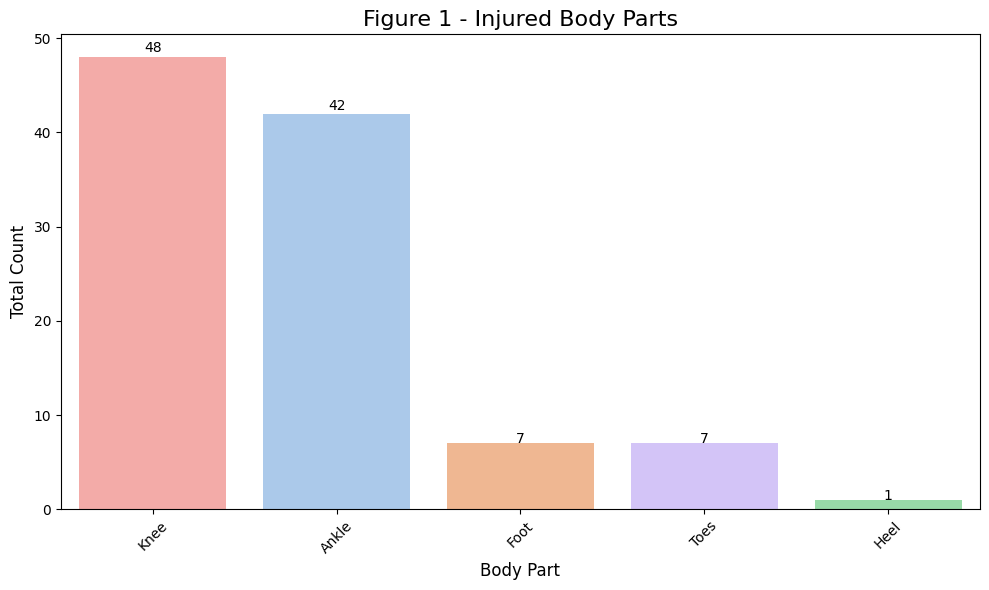

In [13]:
# Calculate the value counts of BodyPart
value = inj_playlist['BodyPart'].value_counts()
label = value.index  

# Create a bar plot 
plt.figure(figsize=(10, 6))  
ax = sns.barplot(x=label, y=value,  hue=label, legend=False, order=label, palette="pastel")

# Add title and labels  
plt.title("Figure 1 - Injured Body Parts", fontsize=16, loc="center")  
plt.xlabel("Body Part", fontsize=12)  
plt.ylabel("Total Count", fontsize=12)  
plt.xticks(rotation=45)  

# Annotate each bar with the count value
for i, v in enumerate(value):
    ax.text(i, v + 0.01*v, str(v), color='black', ha='center', fontsize=10)

plt.tight_layout()  
plt.show()  

### Figure 1 - Insights
1. Knee Injuries Dominate:
- With 48 injuries, the knee is the most frequently injured body part, accounting for 45.7% of all injuries (48 out of 105). This highlights the knee as a critical area for injury prevention and protection.
2. Ankle Injuries Are Significant:
- 42 injuries to the ankle make it the second most common injury, representing 40% of all injuries. This suggests that ankle injuries are nearly as prevalent as knee injuries and may require similar attention in terms of protective measures or training adjustments.
3. Foot and Toes Injuries Are Less Frequent:
- 7 injuries each to the foot and toes account for 6.7% of injuries individually. While less common, these injuries may still warrant attention, especially if they occur in specific play types or conditions.
4. Heel Injuries Are Rare:
- With only 1 injury to the heel, this is the least common injury type, representing less than 1% of all injuries. This could indicate that heel injuries are either rare or under-reported.

#### Let move onto the distribution of Surface and DaysMissed! 

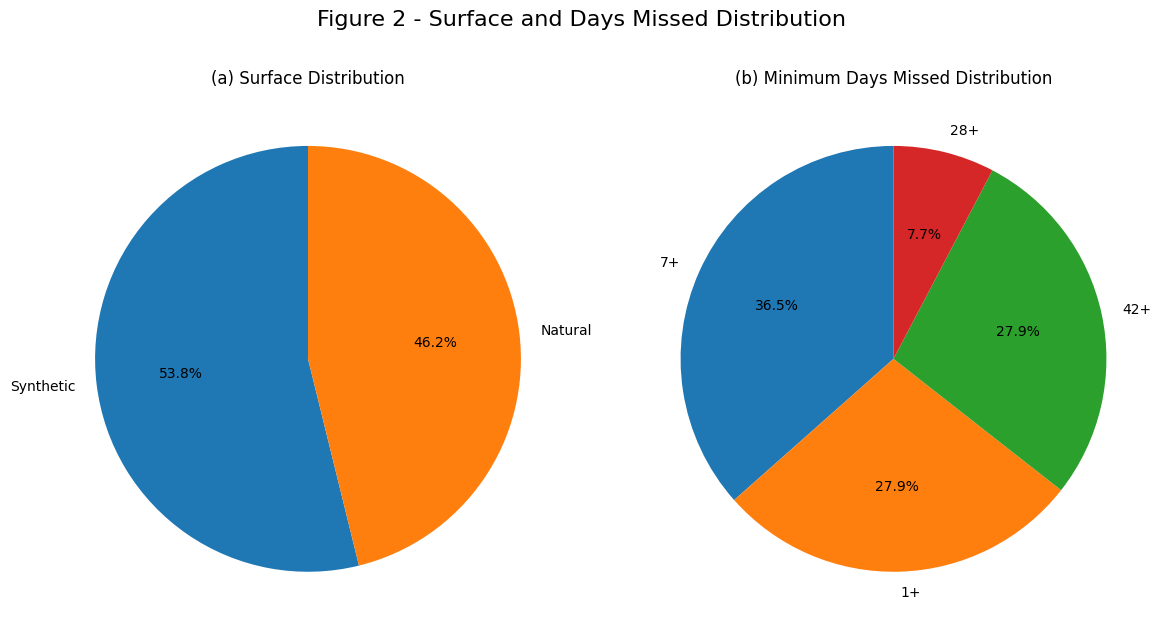

In [14]:
# Filter to records with non-null BodyPart and drop duplicates on PlayKey  
temp = inj_playlist.loc[inj_playlist['BodyPart'].notnull()]  
temp = temp.drop_duplicates(subset="PlayKey", keep="first")  

features = {  
    "Surface": "(a) Surface Distribution",  
    "DaysMissed": "(b) Minimum Days Missed Distribution"  
}  

# Create a subplot (1 row and 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# Loop through each feature to create a pie chart  
for ax, (feature, title) in zip(axes, features.items()):  
    value = temp[feature].value_counts()  
    labels = value.index  
    sizes = value.values  
# Plot pie chart
    wedges, texts, autotexts = ax.pie(  
        sizes,   
        labels=labels,   
        autopct='%1.1f%%',   
        startangle=90,   
        textprops={'color': 'black'}
    )  
    ax.set_title(title)  

# Set the Title
plt.suptitle("Figure 2 - Surface and Days Missed Distribution", fontsize=16, y=1.05)  
plt.tight_layout()  
plt.show()  

### Figure 2 - Insights
- The injury occurrence is relatively balanced between synthetic (53.8%) and natural surfaces (46.2%).
- The data suggests that injuries often incur a significant downtime (7 or more days), with both minimal and extended recovery periods (1 day vs. 42 days) having an identical prevalence of 27.9%, possibly reflecting similar underlying factors.

#### Now lets dig deeper and see the Body Part Injuries by Surface

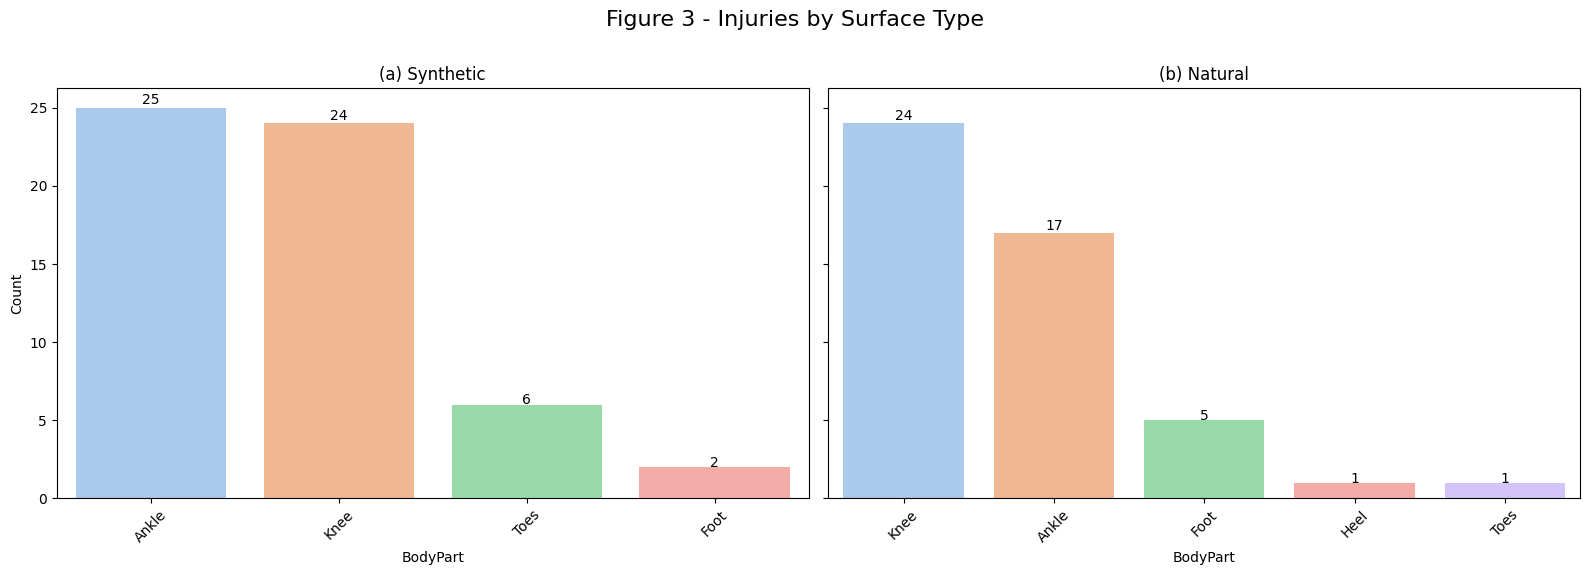

In [15]:
# Define feature parameters  
feature = "BodyPart"  
feature_filter = "Surface"  
feature_values = ["Synthetic", "Natural"]  
subplot_titles = ["(a) Synthetic", "(b) Natural"]  

# Create subplots with 1 row and 2 columns  
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=True)  

# Loop through each surface type  
for ax, surface, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for this surface  
    df = inj_playlist[inj_playlist[feature_filter] == surface]  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  # filter out zero counts
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    sns.barplot(  
        x=plot_df[feature].tolist(),   
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),   
        dodge=False,   
        legend=False,  
        palette="pastel",   
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    ax.set_ylabel("Count")  
    ax.tick_params(axis="x", rotation=45)  

    ax.legend([],[], frameon=False) 

    # Annotate bars with count values  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
        color='black', ha='center', fontsize=10)  

plt.suptitle("Figure 3 - Injuries by Surface Type", fontsize=16, y=0.95)  
plt.tight_layout(rect=[0,0,1,0.94])  
plt.show()  

### Figure 3 - Insights
- While both surfaces show high numbers of Knee and Ankle injuries, there are important differences:
    - On Synthetic surfaces, Ankle injuries occur the most
    - On Natural surfaces, Knee injuries are more common than Ankle injuries
- The surfaces also show different patterns for Foot and Toe injuries:
    - Synthetic surfaces have more Toe injuries
    - Natural surfaces have more Foot injuries
- Heel injuries are rare on both types of surfaces

#### Interesting insights! Now lets move on to seeing how the missed days are distributed by surfaces! 

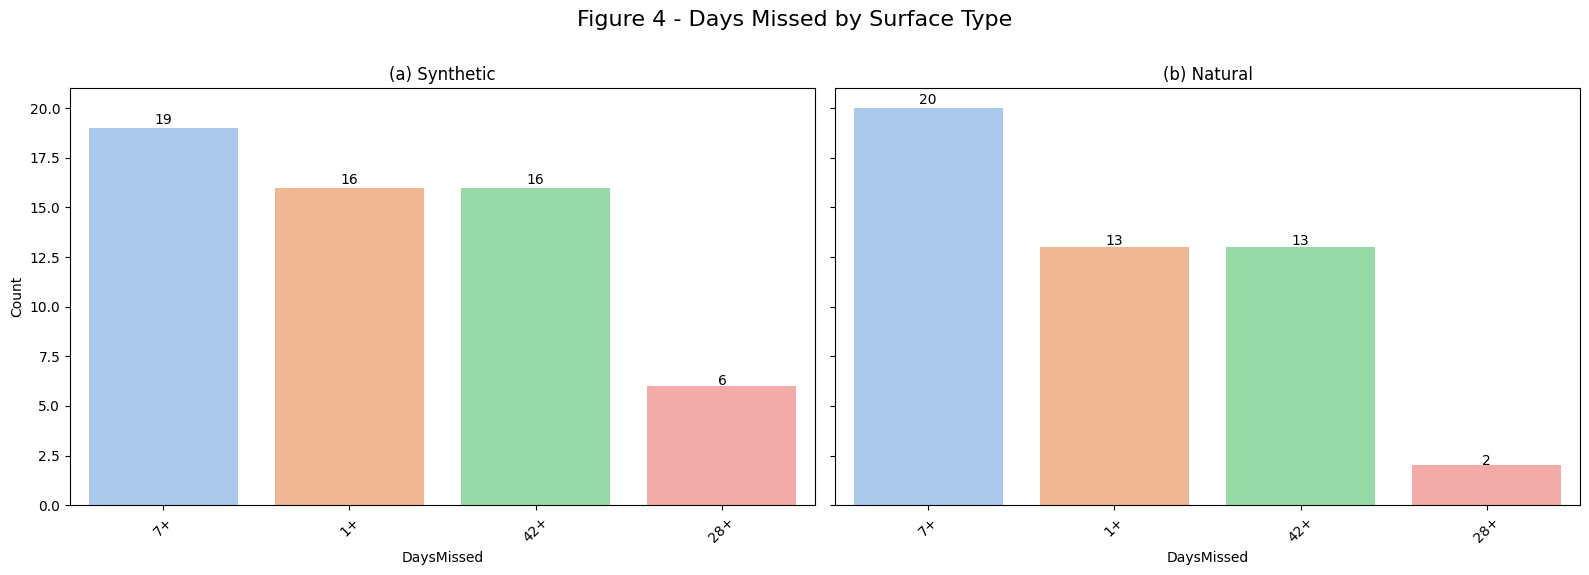

In [16]:
# Define feature parameters  
feature = "DaysMissed"  
feature_filter = "Surface"  
feature_values = ["Synthetic", "Natural"]  
subplot_titles = ["(a) Synthetic", "(b) Natural"]  

# Create subplots with 1 row and 2 columns  
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=True)  

# Loop through each surface type  
for ax, surface, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given surface  
    df = inj_playlist[inj_playlist[feature_filter] == surface]  
    # Compute value counts and filter out zeros if any  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting and ensure order is maintained (descending by count)  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Plot our bar plot
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    ax.set_ylabel("Count")  
    ax.tick_params(axis="x", rotation=45)  

    # Annotate each bar with its count value  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
            color='black', ha='center', fontsize=10)  

    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 4 - Days Missed by Surface Type", fontsize=16, y=0.95)  
plt.tight_layout(rect=[0, 0, 1, 0.94])  
plt.show()  

### Figure 4 - Insights
- Week-long Recovery (7+ days) is the most common on both surfaces:
    - Synthetic: 19 players
    - Natural: 20 players
    - This suggests that most injuries require at least a week of recovery regardless of surface
- Short-term (1+ days) and Long-term (42+ days) Recovery:
    - Slightly higher on Synthetic (16 players each) compared to Natural (13 players each)
- Extended Recovery (28+ days):
    - More frequent on Synthetic surfaces (6 players) than Natural surfaces (2 players)
    - This suggests that injuries on Synthetic surfaces may be more severe that lead to more cases requiring about a month of recovery time

#### Awesome, lets now analyze the total days missed by each body part!  

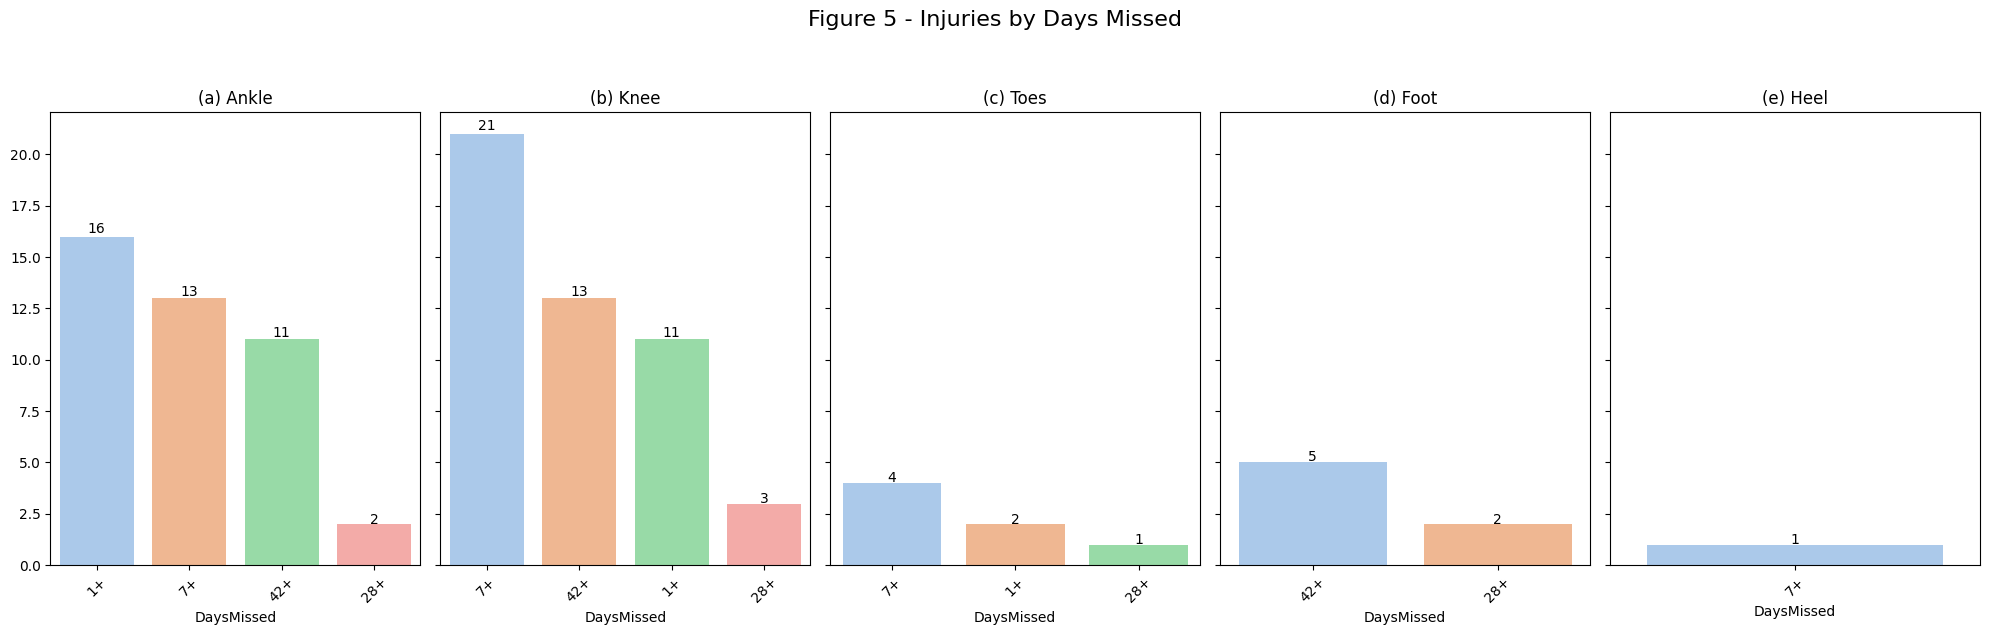

In [17]:
# Define feature parameters  
feature = "DaysMissed"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 1 row and 5 columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each body part  
for ax, body_part, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given body part  
    df = inj_playlist[inj_playlist[feature_filter] == body_part]  
    # Get value counts and filter out zeros  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Create the bar plot  
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    ax.set_ylabel("Count" if ax.get_position().x0 < 0.1 else "")  # Only show y-label on leftmost plot  
    ax.tick_params(axis="x", rotation=45)  

    # Annotate bars with count values  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
            color='black', ha='center', fontsize=10)  

    # Remove extra legend if needed  
    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 5 - Injuries by Days Missed", fontsize=16, y=1.05)  
plt.tight_layout()  
plt.show()  

### Figure 5 - Insights
- Knee injuries show the highest number of week-long recoveries (21 cases)
- Ankle injuries have the most varied recovery times, with cases across all duration categories
- Foot injuries tend to require longer recovery periods (28+ or 42+ days)
- Toes and Heel injuries are less common and generally require shorter recovery periods
- Long-term recovery (42+ days) is most common in ankle and knee injuries

#### Great insights, now can we explore the injuries the occur per play type?

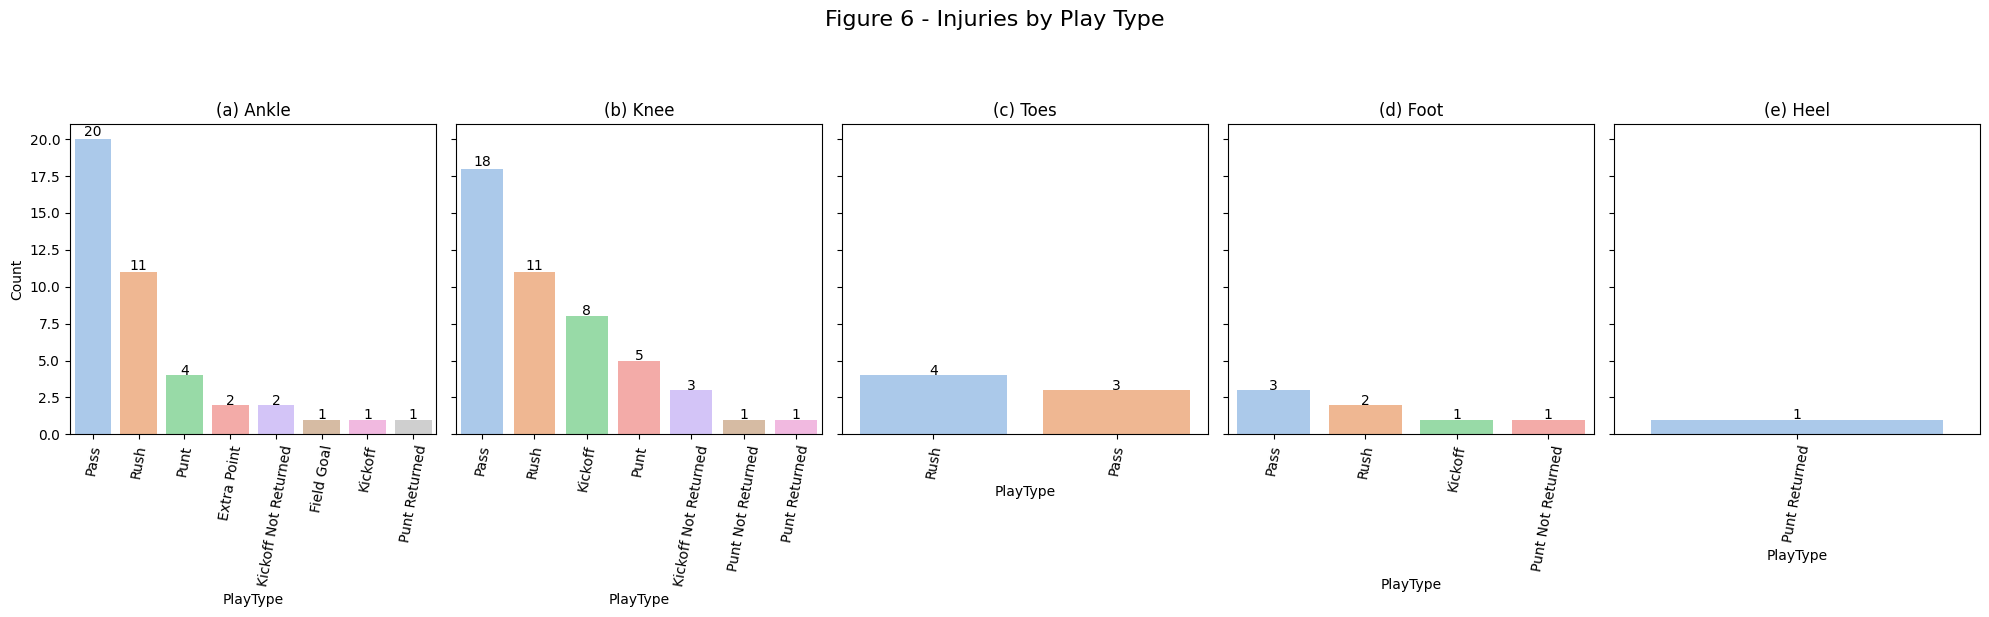

In [18]:
# Define feature parameters  
feature = "PlayType"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 1 row and 5 columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each body part  
for ax, body_part, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given body part  
    df = inj_playlist[inj_playlist[feature_filter] == body_part]  
    # Compute value counts and filter out zero counts  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Create the bar plot 
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    # Only label the y-axis for the leftmost plot  
    if ax == axes[0]:  
        ax.set_ylabel("Count")  
    else:  
        ax.set_ylabel("")  
    ax.tick_params(axis="x", rotation=80)  

    # Annotate each bar with its count value  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
            color='black', ha='center', fontsize=10)  

    # Remove extra legend if needed  
    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 6 - Injuries by Play Type", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 6 - Insights
- Pass and Rush Plays are consistently the most dangerous:
    - Pass plays lead in both ankle (20) and knee (18) injuries
    - Rush plays show consistent numbers for ankle and knee (11 each)
- Special Teams Impact:
    - Kickoff plays show significant risk for knee injuries (11 total)
    - Punt-related plays contribute to injuries across all body parts
    - Field goals and extra points show minimal injury risk
- Risk Distribution:
    - Ankle and knee injuries occur across the widest variety of play types
    - Toes injuries are limited to basic offensive plays (pass and rush)
    - Foot injuries show moderate variety in play types
    - Heel injuries are extremely rare and specific to punt returns
- Regular offensive plays (pass and rush) account for the majority of injuries
- Special teams plays generally show lower injury rates, except for knee injuries during kickoffs

#### Excellent! Time to explore the injures by Roster Position! 

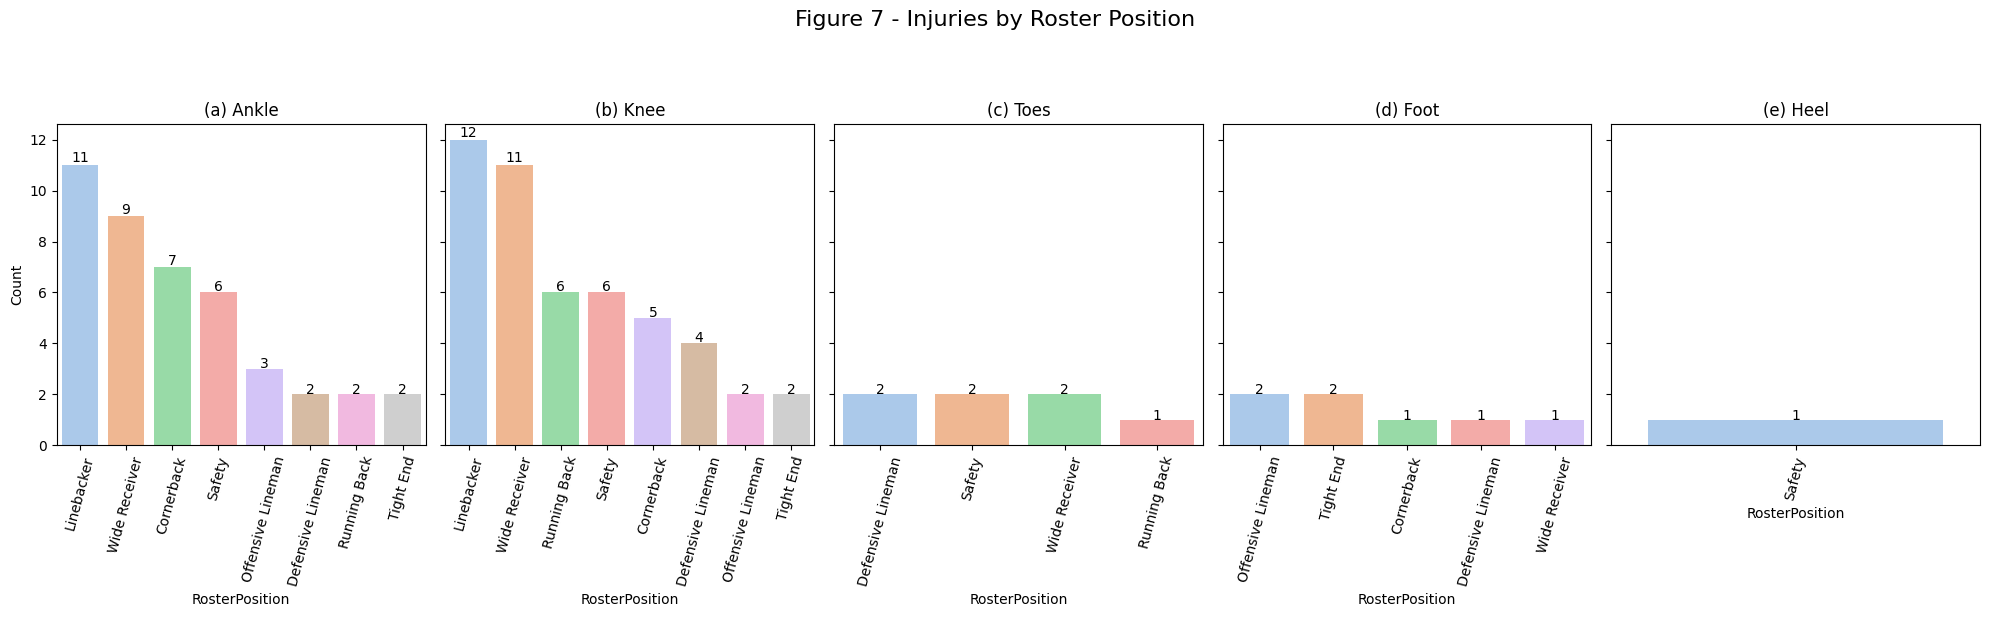

In [19]:
# Define feature parameters
feature = "RosterPosition"
feature_filter = "BodyPart"
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]

# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)

# Loop through each body part
for ax, body_part, title in zip(axes, feature_values, subplot_titles):
    # Filter data for the given body part
    df = inj_playlist[inj_playlist[feature_filter] == body_part]
    # Compute value counts and filter out zero counts
    counts = df[feature].value_counts()
    counts = counts[counts > 0]
    
    # Create DataFrame for plotting
    plot_df = counts.reset_index()
    plot_df.columns = [feature, "Count"]
    
    # Create the bar plot
    sns.barplot(
        x=plot_df[feature].tolist(),
        y=plot_df["Count"].tolist(),
        hue=plot_df[feature].tolist(),
        dodge=False,
        legend=False,
        palette="pastel",
        ax=ax
    )
    
    # Set subplot title and axis labels
    ax.set_title(title)
    ax.set_xlabel(feature)
    # Only label the y-axis for the leftmost plot
    if ax == axes[0]:
        ax.set_ylabel("Count")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=75)
    
    # Annotate each bar with its count value
    for i, row in plot_df.iterrows():
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),
                color='black', ha='center', fontsize=10)
    
    # Remove extra legend if needed
    ax.legend([], [], frameon=False)

plt.suptitle("Figure 7 - Injuries by Roster Position", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() 

### Figure 7 - Insights
- Position-Specific Vulnerabilities:
    - Linebackers are most susceptible to lower extremity injuries (11 ankle, 12 knee)
    - Wide Receivers show high injury rates in both ankle (9) and knee (11)
    - Safeties experience injuries across multiple areas (6 knee, 6 ankle, 2 toes, 1 heel)
- Defensive vs. Offensive Patterns:
    - Defensive players (Linebackers, Cornerbacks, Safeties) show higher ankle injury rates
    - Offensive skill positions (Wide Receivers, Running Backs) are more prone to knee injuries
    - Linemen (both offensive and defensive) generally show lower injury rates
- Injury Distribution:
    - Ankle and knee injuries affect all positions but are most common in high-movement positions
    - Toes, foot, and heel injuries are less common and more evenly distributed across positions
    - Skill positions (Wide Receivers, Running Backs) show vulnerability across multiple injury types
- Risk Assessment:
    - Linebackers and Wide Receivers should be monitored closely for ankle and knee injuries
    - Special attention to defensive players' ankle stability might be warranted
    - Foot, toe, and heel injuries, while less common, affect various positions differently

#### Lets now see how the weather distribution looks per injury type!

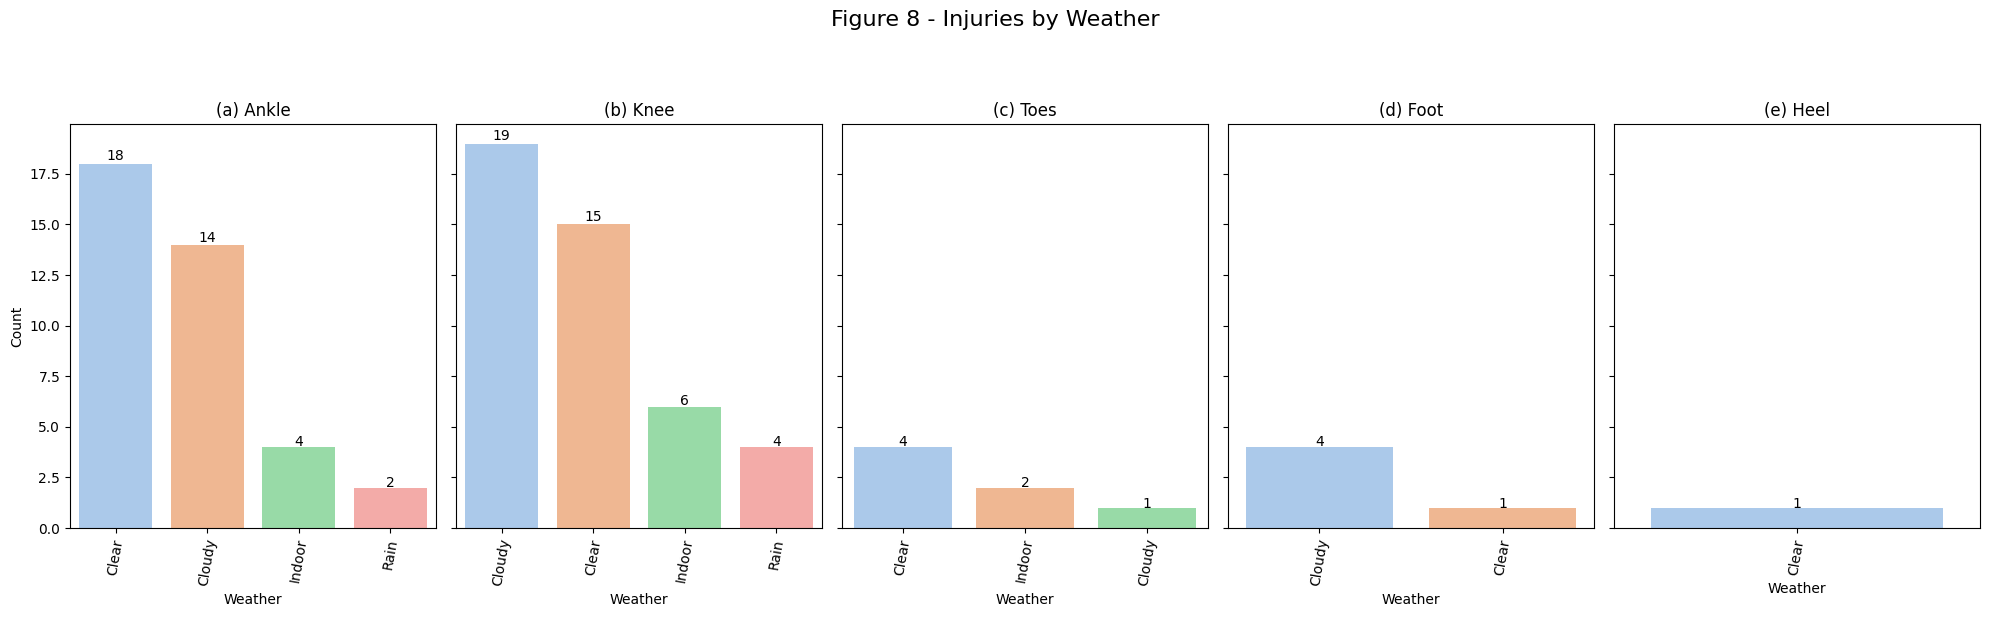

In [20]:
# Define feature parameters  
feature = "Weather"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 1 row and 5 columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)  
 
# Loop through each body part  
for ax, body_part, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given body part  
    df = inj_playlist[inj_playlist[feature_filter] == body_part]  
    # Compute value counts for Weather and filter out zero counts  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Create the bar plot  
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    if ax == axes[0]:  
        ax.set_ylabel("Count")  
    else:  
        ax.set_ylabel("")  
    ax.tick_params(axis="x", rotation=80)  

    # Annotate each bar with its count value  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
            color='black', ha='center', fontsize=10)  

    # Remove extra legend if needed  
    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 8 - Injuries by Weather", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show() 

### Figure 8 - Insights
- Weather Impact Distribution:
    - Combined clear/cloudy conditions account for majority of injuries:
    - Ankle: 32 of 38 injuries (84%)
    - Knee: 34 of 44 injuries (77%)
    - Overall pattern suggests most injuries occur during typical game conditions
- Indoor vs Outdoor Patterns:
    - Controlled Indoor weather shows consistently lower injury rates:
    - Only 12 total injuries across all body parts
    - Knee injuries (6) most common indoors
    - Ankle (4) and toes (2) show moderate indoor occurrence
    - This suggests controlled weather environments may reduce injury risk
- Rain-Related Insights:
    - Minimal injuries during rainy conditions:
        - Only 6 total injuries in rain
        - Concentrated in knee (4) and ankle (2)
        - No rain-related injuries for toes, foot, or heel
        - May indicate more cautious play during wet conditions
- Suggests weather clarity isn't a significant factor in major injury occurrence
- Clear/cloudy conditions warrant highest attention for injury prevention
- Focus injury prevention strategies on regular weather conditions where most injuries occur

#### Okay lets now check out injuries by stadium type! 


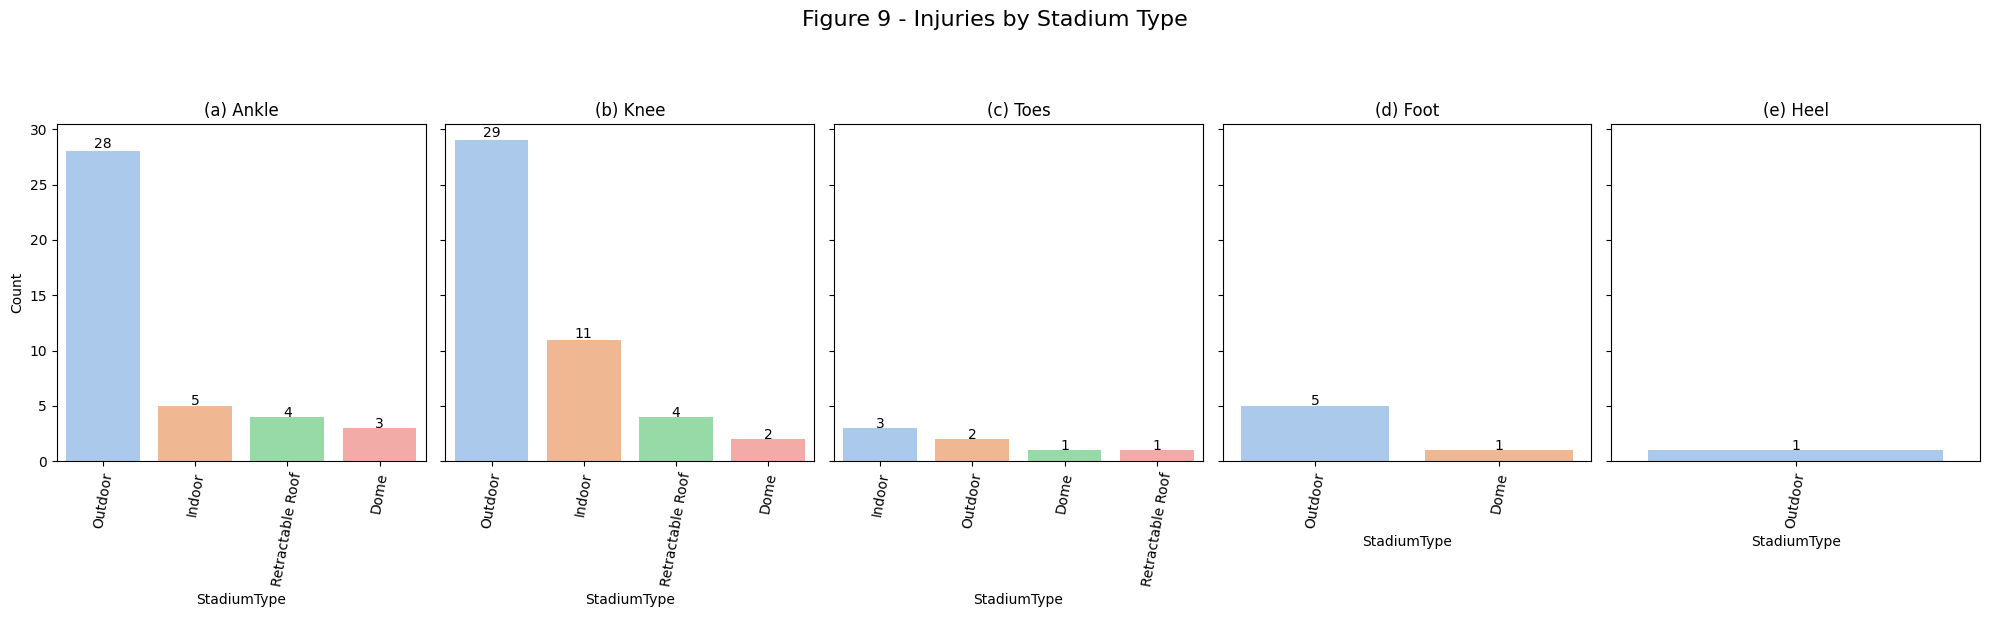

In [21]:
# Define feature parameters  
feature = "StadiumType"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 1 row and 5 columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each body part  
for ax, body_part, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given body part  
    df = inj_playlist[inj_playlist["BodyPart"] == body_part]  
    # Compute value counts for StadiumType and filter out zero counts  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Create the bar plot  
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel(feature)  
    if ax == axes[0]:  
        ax.set_ylabel("Count")  
    else:  
        ax.set_ylabel("")  
    ax.tick_params(axis="x", rotation=80)  

    # Annotate each bar with its count value  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
        color='black', ha='center', fontsize=10)  

    # Remove extra legend if needed  
    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 9 - Injuries by Stadium Type", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 9 - Insights
- Outdoor Dominance:
    - Outdoor stadiums account for the majority of injuries across body parts. 
    - This reflects that most NFL venues are outdoor facilities, where weather variability and field conditions can contribute to a higher injury risk.
- Controlled Environments Offer Advantages:
    - Indoor facilities, domes, and retractable roofs generally show reduced injury counts. 
- Influence on Player Preparation and Equipment:
    - The higher injury rates in outdoor settings suggest that teams might need to adjust training regimens, invest in enhanced field maintenance, and possibly optimize equipment choices (e.g., cleat type) when playing under variable outdoor conditions.
- The reduced injury counts in controlled environments such as retractable roofs and domes support the modern trend toward hybrid stadium designs. 

#### Time to explore the temperature distribution by injury type! 

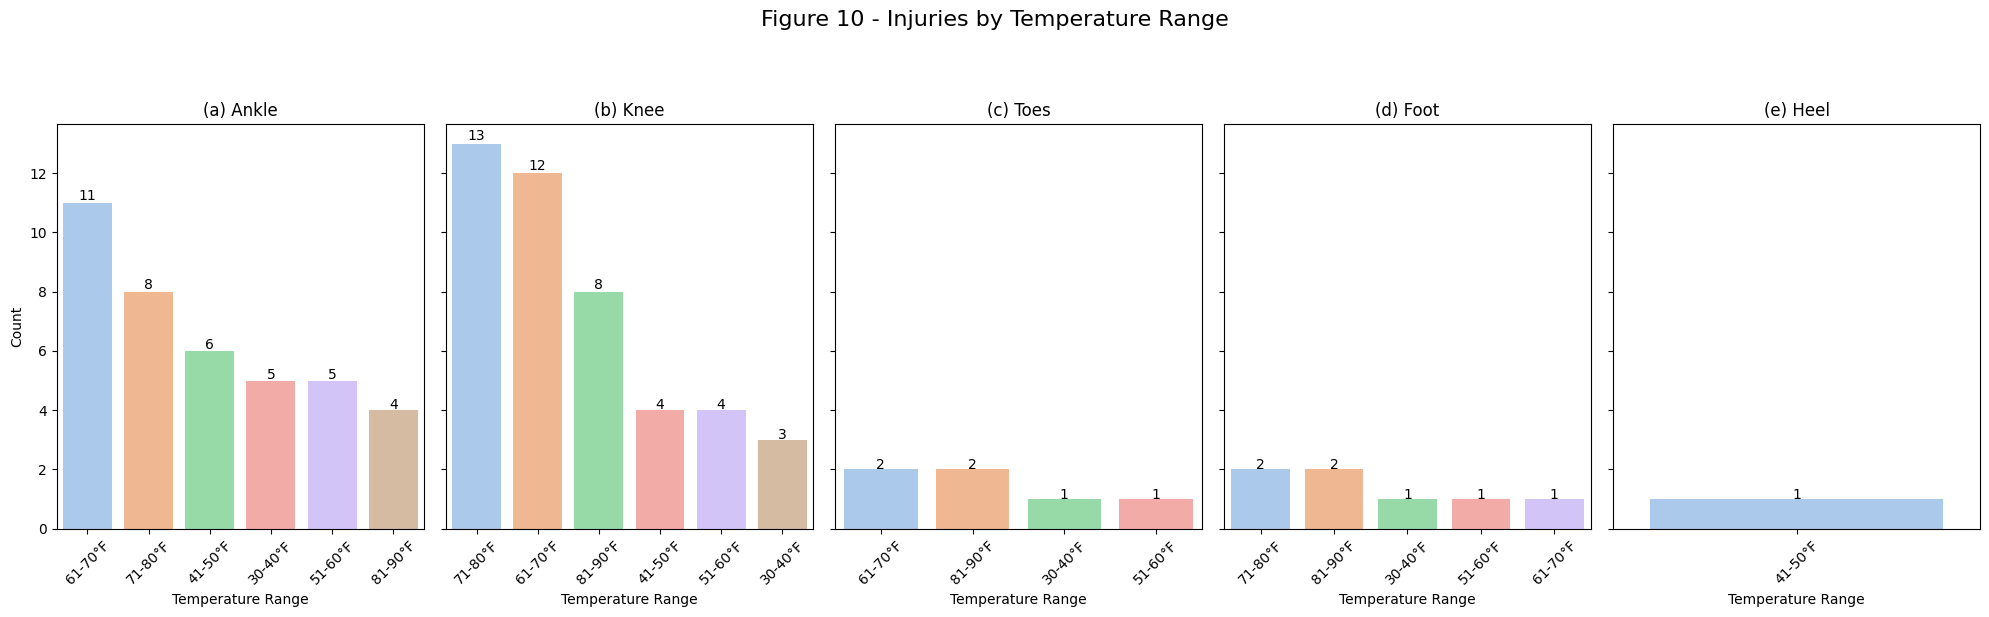

In [22]:
#Define temperature bins and labels  
temp_bins = [30, 40, 50, 60, 70, 80, 90]  
temp_labels = ['30-40°F', '41-50°F', '51-60°F', '61-70°F', '71-80°F', '81-90°F']  

# Add temperature column  
inj_playlist['Temperature'] = pd.cut(inj_playlist['Temperature'],   
                    bins=temp_bins,   
                    labels=temp_labels,   
                    include_lowest=True)  

# Define feature parameters  
feature = "Temperature"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 1 row and 5 columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each body part  
for ax, body_part, title in zip(axes, feature_values, subplot_titles):  
    # Filter data for the given body part  
    df = inj_playlist[inj_playlist[feature_filter] == body_part]  
    # Compute value counts and filter out zero counts  
    counts = df[feature].value_counts()  
    counts = counts[counts > 0]  

    # Create DataFrame for plotting  
    plot_df = counts.reset_index()  
    plot_df.columns = [feature, "Count"]  

    # Create the bar plot   
    sns.barplot(  
        x=plot_df[feature].tolist(),  
        y=plot_df["Count"].tolist(),  
        hue=plot_df[feature].tolist(),  
        dodge=False,  
        legend=False,  
        palette="pastel",  
        ax=ax  
    )  

    # Set subplot title and axis labels  
    ax.set_title(title)  
    ax.set_xlabel("Temperature Range")  
    # Only label the y-axis for the leftmost plot  
    if ax == axes[0]:  
        ax.set_ylabel("Count")  
    else:  
        ax.set_ylabel("")  
    ax.tick_params(axis="x", rotation=45)  

    # Annotate each bar with its count value  
    for i, row in plot_df.iterrows():  
        ax.text(i, row["Count"] + 0.01 * row["Count"], int(row["Count"]),  
                color='black', ha='center', fontsize=10)  

    # Remove extra legend if needed  
    ax.legend([], [], frameon=False)  

plt.suptitle("Figure 10 - Injuries by Temperature Range", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 10 - Insights
- Most injuries occur in moderate to warm temperatures (61-80°F), with ankle and knee injuries showing the highest frequencies in this range.
- Ankle and knee injuries dominate the dataset, with significantly higher counts across all temperature ranges compared to toes, foot, and heel injuries.
- Extreme temperatures show fewer injuries overall: cold temperatures (30-40°F) account for only 10 total injuries across all body parts, while hot temperatures (81-90°F) show 16 total injuries.
- Toes, foot, and heel injuries are relatively rare, with sporadic occurrences across temperature ranges and no clear pattern, suggesting temperature may not be a significant factor for these injury types.

### Are there any corralations between our features and injuried body part?

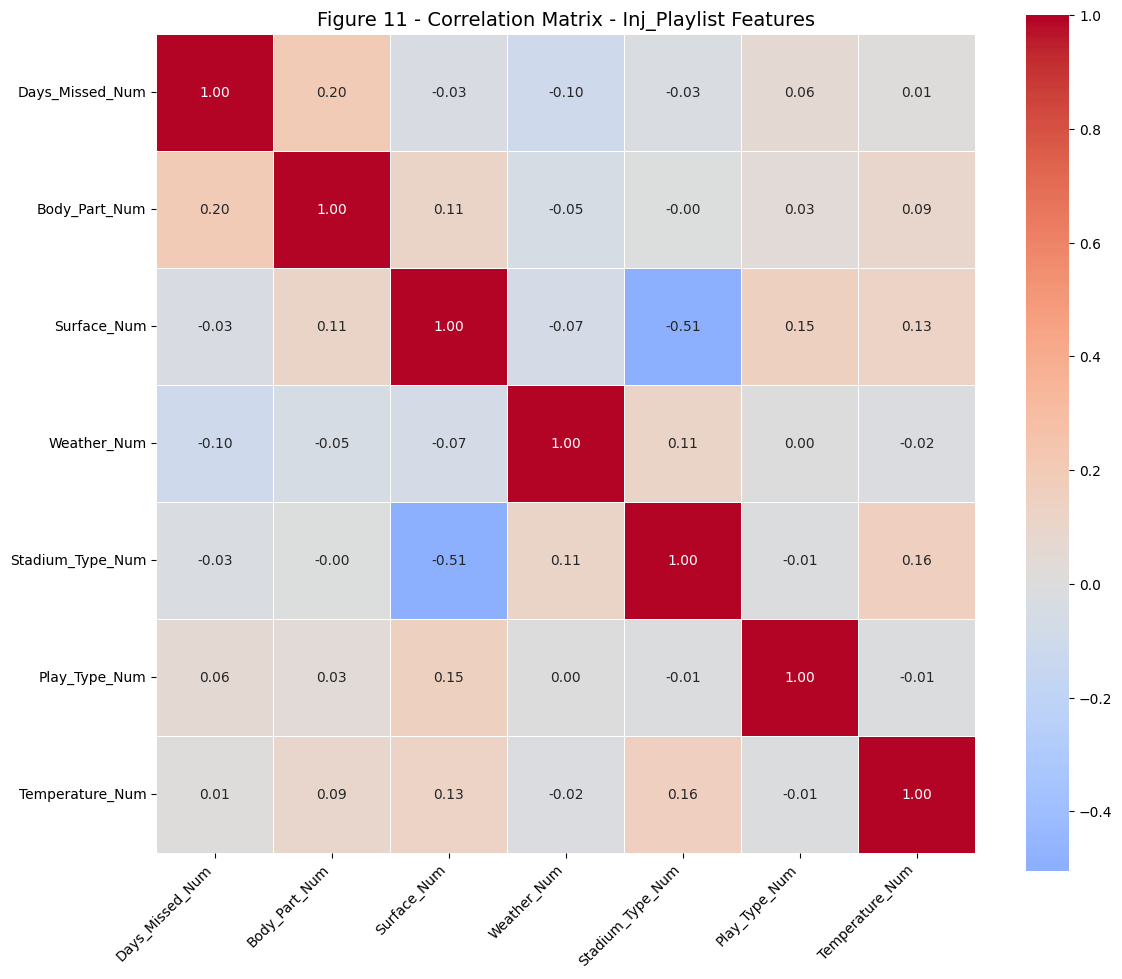

In [23]:
# First we should attempt converting non-numeric columns into numerical

# Create mapping dictionaries for categorical variables  
days_miss_dict = {  
    "1+" : 1,   
    "7+" : 2,   
    "28+" : 3,   
    "42+" : 4  
}  

body_part_dict = {  
    "Ankle" : 1,   
    "Knee" : 2,   
    "Toes" : 3,   
    "Foot" : 4,   
    "Heel" : 5  
}  

surface_dict = {  
    "Synthetic" : 0,   
    "Natural" : 1  
}  

stadium_dict = {  
    "Outdoor" : 1,   
    "Indoor" : 2,   
    "Dome" : 3,   
    "Retractable Roof" : 4 
}  

playtype_dict = {  
    'Pass' : 1,  
    'Rush' : 2,  
    'Kickoff' : 3,  
    'Kickoff Not Returned' : 4,  
    'Kickoff Returned' : 5,                 
    'Field Goal' : 6,  
    'Punt' : 7,  
    'Punt Not Returned' : 8,  
    'Punt Returned' : 9,  
    'Extra Point' : 10  
}  

weather_dict = {
    'Cloudy' : 1,
    'Clear' : 2,
    'Indoor' : 3,
    'Rain' : 4,
    'Snow' : 5
}

temperature_dict = {
    '30-40°F' : 1, 
    '41-50°F' : 2,
    '51-60°F' : 3,
    '61-70°F' : 4,
    '71-80°F' : 5,
    '81-90°F' : 6  
}

# Create a copy of the dataframe 
df_corr = inj_playlist.copy()  

# Apply mappings and create new columns  
df_corr['Days_Missed_Num'] = df_corr["DaysMissed"].map(days_miss_dict)  
df_corr['Body_Part_Num'] = df_corr["BodyPart"].map(body_part_dict)  
df_corr['Surface_Num'] = df_corr["Surface"].map(surface_dict)  
df_corr['Stadium_Type_Num'] = df_corr["StadiumType"].map(stadium_dict)  
df_corr['Play_Type_Num'] = df_corr["PlayType"].map(playtype_dict)  
df_corr['Weather_Num'] = df_corr["Weather"].map(weather_dict)
df_corr['Temperature_Num'] = df_corr["Temperature"].map(temperature_dict)

# Select numeric columns for correlation  
numeric_cols = ['Days_Missed_Num', 'Body_Part_Num', 'Surface_Num', 'Weather_Num',  
                        'Stadium_Type_Num', 'Play_Type_Num', 'Temperature_Num']  

# Create correlation matrix  
correlation_matrix = df_corr[numeric_cols].corr()  

# Create heatmap  
plt.figure(figsize=(12, 10))  
sns.heatmap(correlation_matrix,  
            annot=True,  
            fmt='.2f',  
            cmap='coolwarm',  
            center=0,  
            square=True,  
            linewidths=.5)  

plt.title("Figure 11 - Correlation Matrix - Inj_Playlist Features", fontsize=14)  
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()  

### Figure 11 - Insights
- Most features show weak correlations (|r| < 0.3), suggesting that our features are largely independent of each other.
- The strongest correlation exists between Surface Type and Stadium Type (r ≈ -0.51), indicating a moderate inverse relationship. 


#### While we didn't find strong correlations between our features, this analysis was a crucial step in understanding our dataset's structure. Let now move on to our next dataset.

## Exploring the Player Track Data

Time to explore the large player track dataset! We have a significant amount of route data so lets start with the routes for injured players on synthetic surfaces. 

##### Quick Reminder: Player_track Data Columns
x: X-coordinate on the field (in yards)  
     - 0 is the back of one endzone  
     - 120 is the back of the other endzone  
     - 10 to 110 represents the playing field between the endzones  
       
y: Y-coordinate on the field (in yards)  
     - 0 is one sideline  
     - 53.3 is the other sideline  
     - ~26.65 represents the middle of the field  

dir: Direction of movement (in degrees)(in yards)  
     - Indicates the angle (relative to a fixed reference axis) at which the player is moving <BR/>
     - Helps determine the trajectory of movement across the field
     
dis: Distance covered (in yards) during the time interval <BR/>
        - Represents the incremental distance traveled by the player between tracking points <BR/>

o: Orientation of the player (in degrees) <BR/>
        - Captures the direction in which the player is facing, which may differ from their direction of movement <BR/>
        - Useful to understand player posture and anticipation during plays <BR/>

s: Speed of the player (in yards per second) <BR/>
        - Measures how quickly the player is moving <BR/>

PlayKey: Unique identifier for each play  
     - Used to match plays between tracking and injury datasets  
       
 Time: Timestamp of the tracking data point  
     - Shows progression of player movement during the play  
       
 Event: Game event occurring at that moment  
     - e.g., "snap", "tackle", "pass_outcome_caught"  

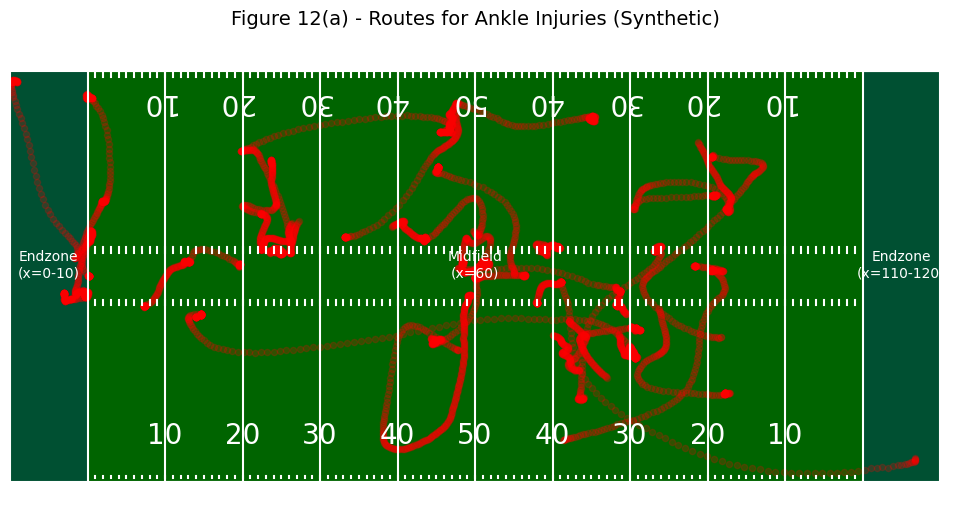

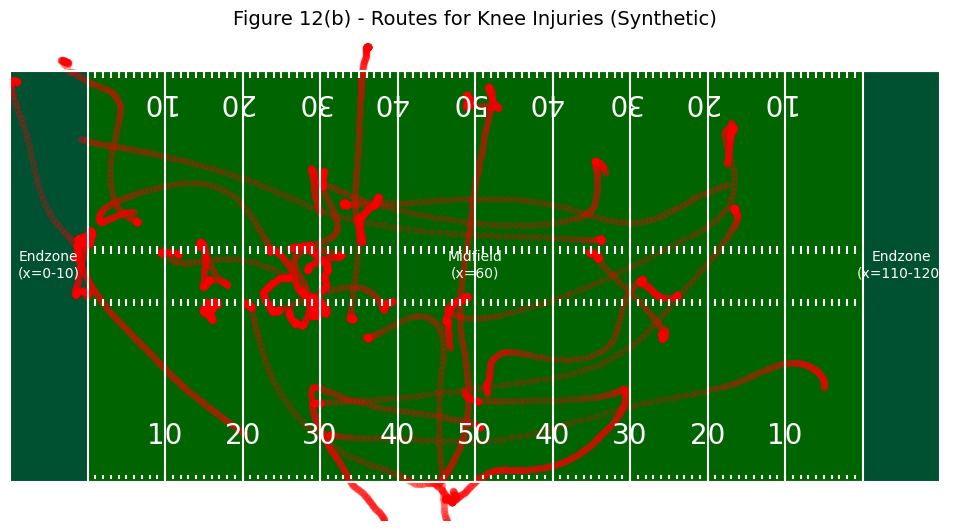

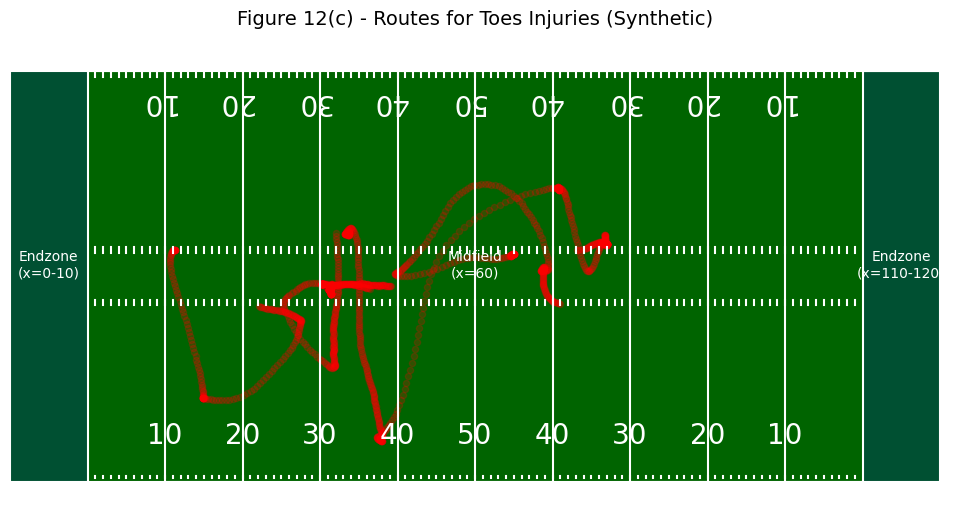

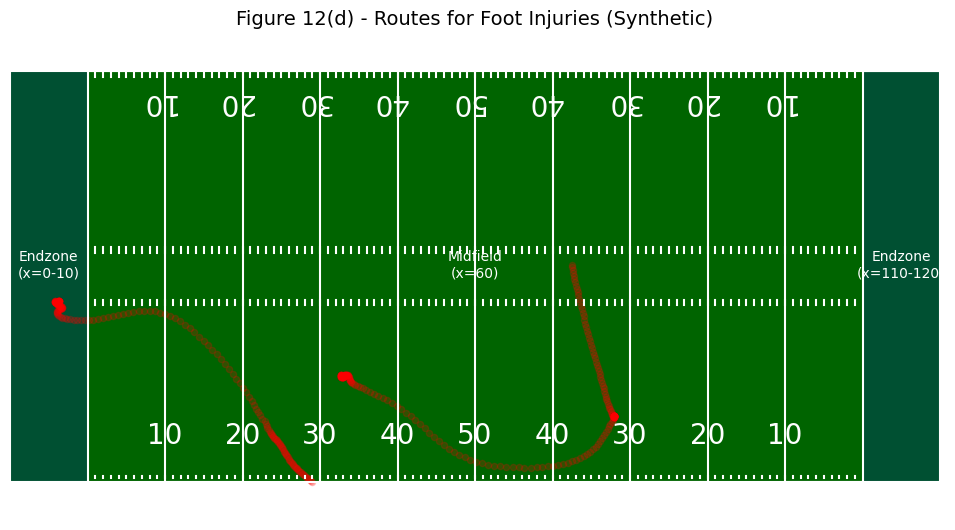

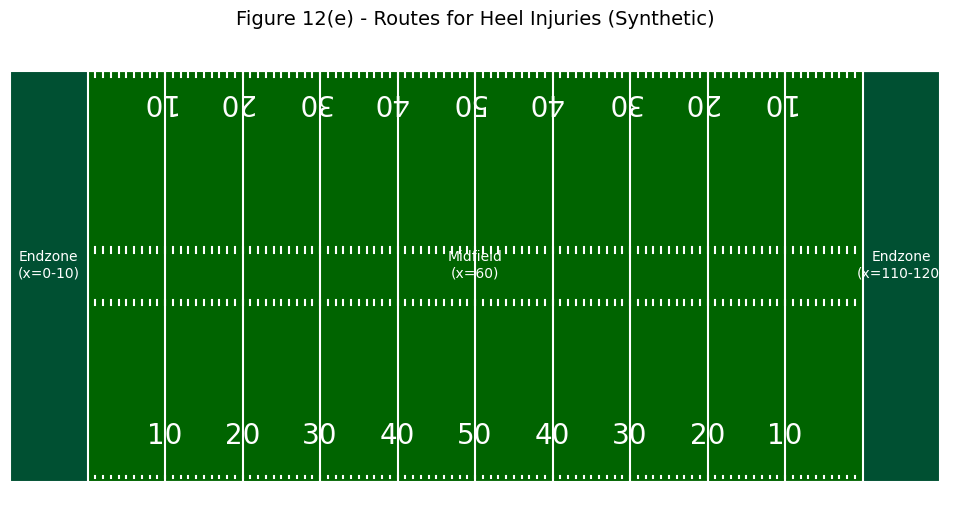

In [24]:
def plot_injury_routes(body_part, title, color='red', alpha=0.2):  
    # Filter synthetic injuries  
    df_syn = inj_playlist[(inj_playlist["Surface"] == "Synthetic") &   
                    (inj_playlist["BodyPart"] == body_part)]  
    df_syn_list = df_syn['PlayKey'].tolist()  

    # Create football field  
    fig, ax = create_football_field()  

    # Add field annotations  
    plt.text(5, 26.65, 'Endzone\n(x=0-10)', color='white', ha='center')  
    plt.text(115, 26.65, 'Endzone\n(x=110-120)', color='white', ha='center')  
    plt.text(60, 26.65, 'Midfield\n(x=60)', color='white', ha='center')  

    # Plot player routes  
    for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):  
        inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color=color, alpha=alpha)  

    plt.title(title, fontsize=14)  
    plt.show() 

# Plot Injury Routes
body_parts = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  

for i, body_part in enumerate(body_parts, 1):  
    plot_title = "Figure 12(" + chr(96+i) + ") - Routes for " + body_part + " Injuries (Synthetic)"  
    plot_injury_routes(body_part, plot_title)  

### Figure 12 - Insights
- There is no visuble pattern for injury routes
- Ankle and Knee injuries show the highest frequency on synthetic surfaces
- Foot injuries show a strong sideline tendency
- Knee injuries are the only type showing significant out-of-bounds tracking points
- Toe injuries tend to occur between the numbers

#### Now lets check injury routes on Natural surfaces

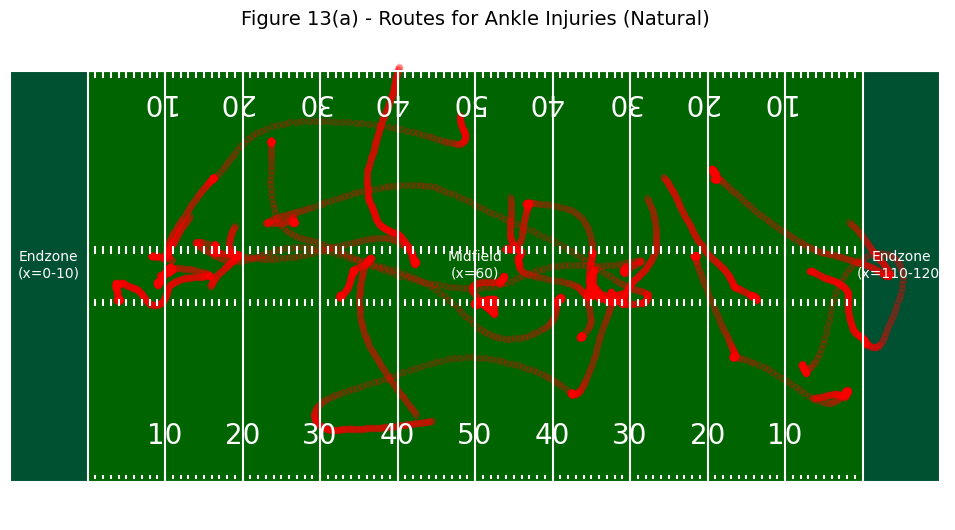

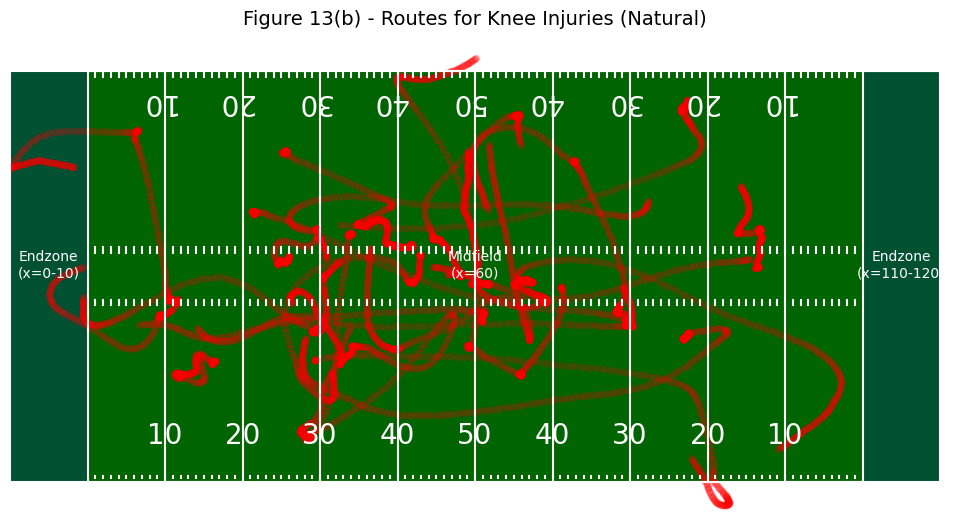

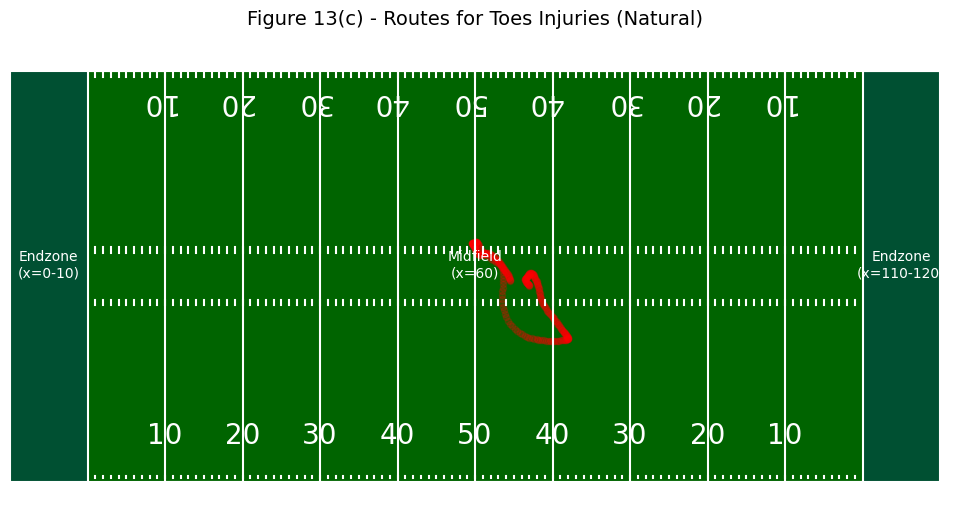

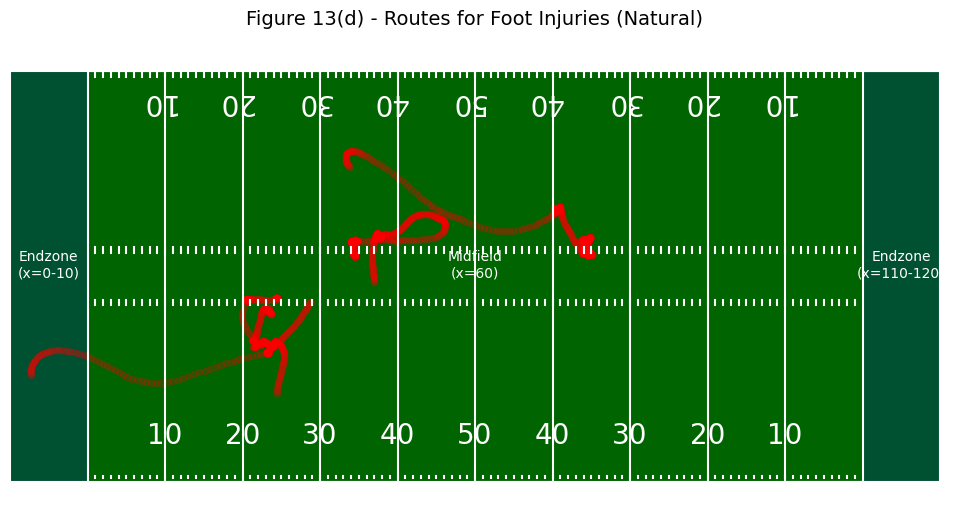

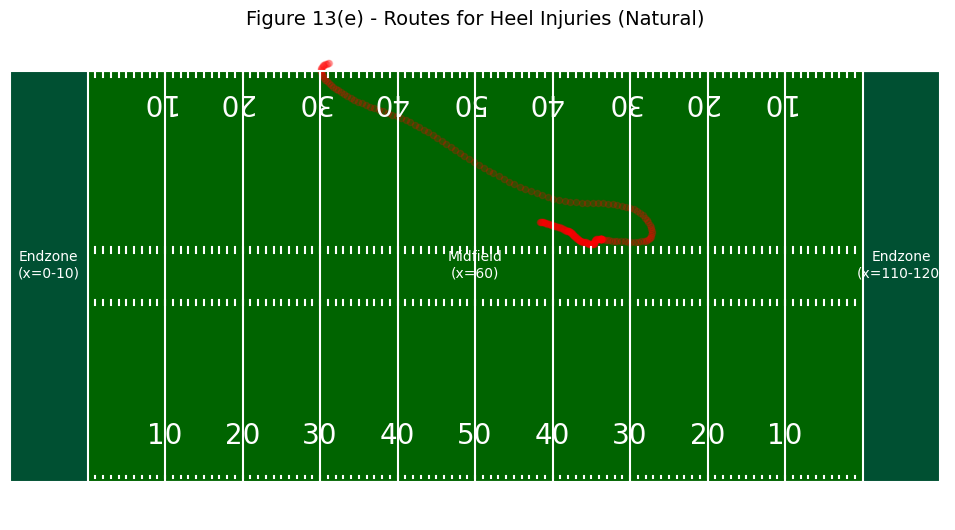

In [25]:
def plot_injury_routes(body_part, title, color='red', alpha=0.2):  
    # Filter Natural injuries  
    df_nat = inj_playlist[(inj_playlist["Surface"] == "Natural") &   
                    (inj_playlist["BodyPart"] == body_part)]  
    df_nat_list = df_nat['PlayKey'].tolist()  

    # Create football field  
    fig, ax = create_football_field()  

    # Add field annotations  
    plt.text(5, 26.65, 'Endzone\n(x=0-10)', color='white', ha='center')  
    plt.text(115, 26.65, 'Endzone\n(x=110-120)', color='white', ha='center')  
    plt.text(60, 26.65, 'Midfield\n(x=60)', color='white', ha='center')  

    # Plot player routes  
    for playkey, inj_play in player_track.query('PlayKey in @df_nat_list').groupby('PlayKey'):  
        inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color=color, alpha=alpha)  

    plt.title(title, fontsize=14)  
    plt.show() 

# Plot Injury Routes
body_parts = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  

for i, body_part in enumerate(body_parts, 1):  
    plot_title = "Figure 13(" + chr(96+i) + ") - Routes for " + body_part + " Injuries (Natural)"  
    plot_injury_routes(body_part, plot_title)  

### Figure 13 - Insights
- There is no visible, consistent pattern in the routing for ankle, knee, and heel injuries.
- A concentrated number of knee injury routes occur inside the numbers. Moreover, there is a higher midfield presence compared to synthetic surfaces.
- Toe injury routes tend to occur between the numbers and are more concentrated near the midfield.
- Foot injuries generally occur between the center of the sidelines, with part of their route positioned closer to the center of the sidelines.

##### For the other features on `player_track` (`time`, `x`, `y`, `dir`, `dis`, `o`, `s`), let's calculate the difference between the feature value at the end of the play and the start of the play, and call it "Delta" for time, x, y, and direction. For distance we will sum all the distances between consecutive points and for speed we will collect the max speed. <br>

Lets review the following deltas and how they impact our injury types! 

1. Delta Time
    - Measures the duration of the play from start to finish
    - Helps understand if longer plays correlate with higher injury risks

2. Delta X
    - Represents net movement along the length of the field (end zone to end zone)
    - Positive value: player moved toward the opposing end zone
    - Negative value: player moved toward their own end zone
    - Helps analyze if forward/backward movement patterns relate to injuries

3. Delta Y
    - Shows net lateral movement (sideline to sideline)
    - Positive value: player moved toward one sideline
    - Negative value: player moved toward the opposite sideline
    - Useful for identifying if sideline-to-sideline movements increase injury risk

4. Delta Direction
    - Indicates the total change in the player's movement direction
    - Large absolute values suggest sharp turns or direction changes
    - Small absolute values indicate more linear movement
    - Important for identifying if sudden direction changes correlate with injuries

5. Total Distance
    - Shows the total distance covered during the play
    - Helps understand if covering more ground increases injury risk

6. Delta Orientation
    - Measures how much the player's body orientation changed
    - Large values indicate lots of turning or spinning
    - Small values suggest the player maintained consistent orientation
    - Useful for identifying if rapid body position changes contribute to injuries

7. Max Speed
    - Shows the max velocity from start to end of play
    - Important for understanding how max speed on different surfaces relate to injuries

In [26]:
# Initialize a dictionary with delta columns, starting with zero values 
df_data = {"delta_time": [0.0], "delta_x": [0.0], "delta_y": [0.0],
            "delta_dir": [0.0], "delta_orientation": [0.0], "max_speed": [0.0]} 

# Create a temporary DataFrame for calculations  
df_temp_c = pd.DataFrame(columns=["delta_time", "delta_x", "delta_y", "delta_dir", "total_distance", "delta_o", "max_speed"])  

# Filter injury playlist to only include rows where BodyPart is not null  
df_temp_b = inj_playlist[inj_playlist.BodyPart.notnull()]  

# Initialize a list to hold each play's delta DataFrame  
delta_list = []  

# Iterate through each injury play  
for i in range(len(df_temp_b)):
    # Get the PlayKey for the current injury  
    play_key = df_temp_b["PlayKey"].values[i]

    # Filter player tracking data for the current play using the PlayKey  
    play_data = player_track[player_track["PlayKey"] == play_key]
    
    # Proceed only if there are at least two tracking points  
    if play_data.shape[0] >= 2:
        # Calculate deltas between consecutive points for distance traveled
        dx = play_data['x'].diff()
        dy = play_data['y'].diff()
        point_to_point_distances = np.sqrt(dx**2 + dy**2)
        total_distance = point_to_point_distances.sum()
        
        # Get the first row (start of play)  
        temp_a = play_data.head(1)
        # Get the last row (end of play)  
        temp_b = play_data.tail(1)
        
        # Calculate the deltas between start and end of play for other metrics
        # For time, x, y, dir and o (orientation difference)
        df_temp_c = temp_b[["time", "x", "y", "dir", "o"]].reset_index(drop=True) - temp_a[["time", "x", "y", "dir", "o"]].reset_index(drop=True)
        
        # Rename columns: delta_time, delta_x, delta_y, delta_dir, delta_orientation
        df_temp_c.columns = ["delta_time", "delta_x", "delta_y", "delta_dir", "delta_orientation"]
        
        # Calculate max_speed from the entire play
        max_speed = play_data['s'].max()
        
        # Add total_distance and max_speed columns
        df_temp_c["total_distance"] = total_distance
        df_temp_c["max_speed"] = max_speed
        
        # Append the temporary DataFrame to the list  
        delta_list.append(df_temp_c)

# Concatenate all delta DataFrames collected in the list into a single DataFrame  
df_delta = pd.concat(delta_list, ignore_index=True)

In [27]:
inj_track = pd.concat([injury_record, df_delta], axis=1)

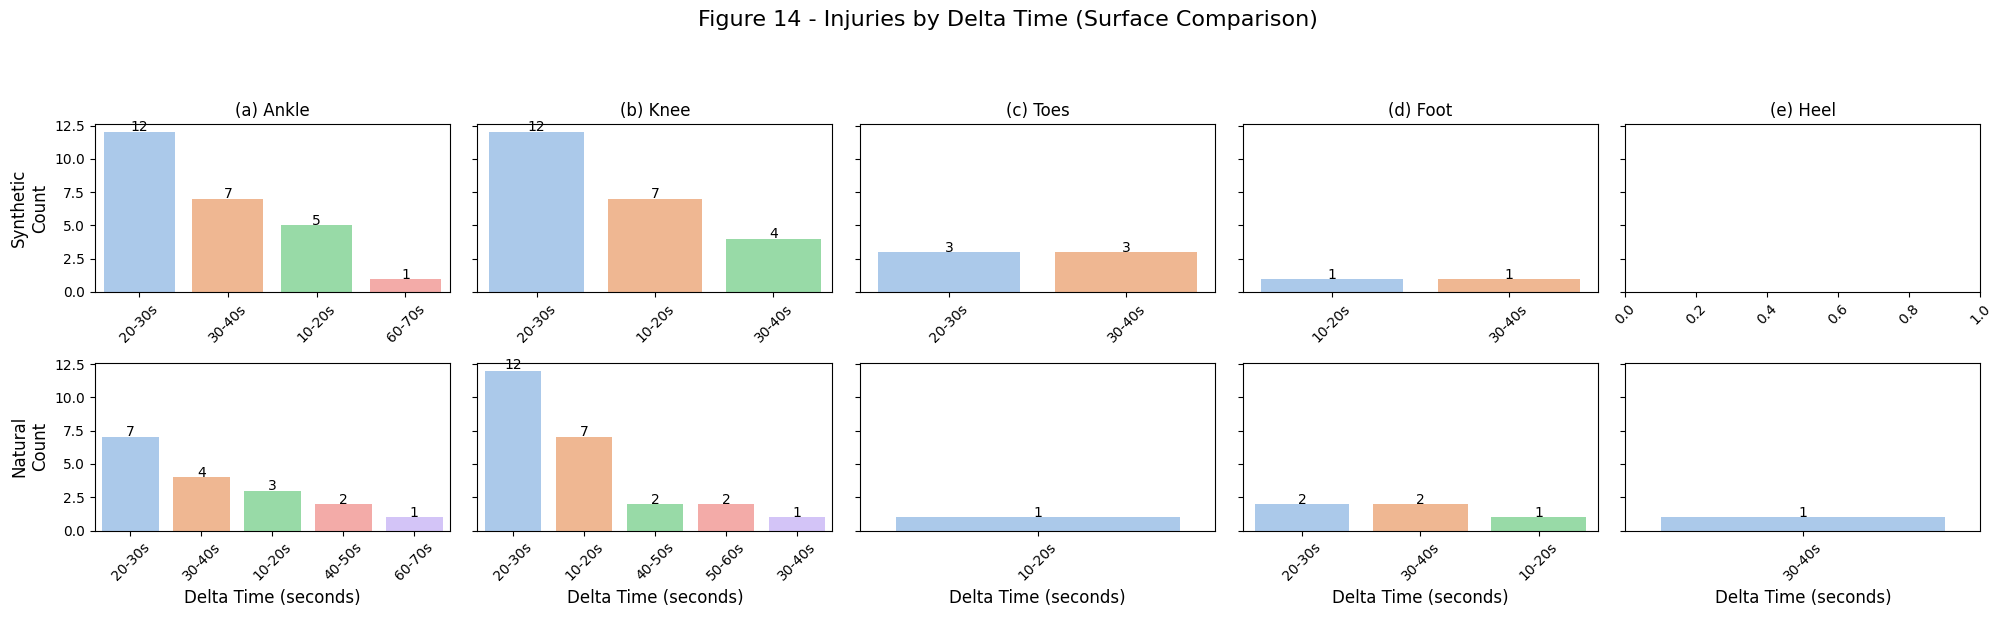

In [28]:
# Define delta_time bins and labels  
delta_bins = [-5, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  
delta_labels = ['(-5)-0s', '0-10s', '10-20s', '20-30s', '30-40s', '40-50s', '50-60s', '60-70s', '70-80s', '80-90s']  


# Add delta_time column with bins  
inj_track['delta_time_binned'] = pd.cut(inj_track['delta_time'],   
                    bins=delta_bins,   
                    labels=delta_labels,   
                    include_lowest=True)  

# Define feature parameters  
feature = "delta_time_binned"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
surface_types = ["Synthetic", "Natural"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  

# Create subplots with 2 rows and 5 columns  
fig, axes = plt.subplots(2, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each surface type (rows) and each body part (columns)  
for row, surface in enumerate(surface_types):  
    for col, (body_part, title) in enumerate(zip(feature_values, subplot_titles)):  
        ax = axes[row, col]  
        
        # Filter data for the given surface type and body part  
        df_filtered = inj_track[(inj_track['Surface'] == surface) &   
                                (inj_track[feature_filter] == body_part)]  

        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  
        
        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, "Count"]  

        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df["Count"].tolist(),  
            hue=plot_df[feature].tolist(),  
            dodge=False,  
            palette="pastel",  
            legend=False,  
            ax=ax  
        )  
        
        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(title, fontsize=12)  
        if col == 0:  
            ax.set_ylabel(surface + "\nCount", fontsize=12)  
        else:  
            ax.set_ylabel("")  
        
        # Only label the x-axis for lower row plots  
        if row == 1:  
            ax.set_xlabel("Delta Time (seconds)", fontsize=12)  
        else:  
            ax.set_xlabel("")  
        
        ax.tick_params(axis="x", rotation=45)  
        
        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
            ax.text(i, row_data["Count"] + 0.01 * row_data["Count"],   
                    int(row_data["Count"]),  
                    color='black', ha='center', fontsize=10)  

        ax.legend([], [], frameon=False)  

plt.suptitle("Figure 14 - Injuries by Delta Time (Surface Comparison)", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 14 - Insights
- The analysis of injury timing reveals that most lower extremity injuries occur during plays lasting between 20-40 seconds, with the 20-30 second range being particularly significant. 
- Knee injuries show the highest concentration in this window (24 injuries in 20-30s, 14 in 10-20s), followed closely by ankle injuries (19 in 20-30s, 11 in 30-40s). 
- Other lower extremity injuries (toes, foot, and heel) occur less frequently but follow a similar temporal pattern, primarily clustering in the 20-40 second range. 
- This consistent pattern across injury types suggests that plays lasting around 20-30 seconds may present the highest risk for lower extremity injuries, potentially due to fatigue or specific play patterns that develop during this timeframe.
- On synthetic turf, ankle injuries peak earlier and more sharply (e.g., 12 cases in 20–30s) compared to natural surfaces, where injuries are lower overall and distributed over several intervals, suggesting differences in initial impact forces or surface traction.
- Both surfaces show high knee injury counts in the 20–30s range. However, natural surfaces exhibit a broader spread with more injuries occurring during extended play (40–60s), which may indicate that sustained stresses or delayed fatigue contribute differently on natural fields.
- The presence of a sole heel injury on natural turf versus no corresponding instances on synthetic turf hints at potential differences in shock absorption or traction, however we would need more data to determine this. 

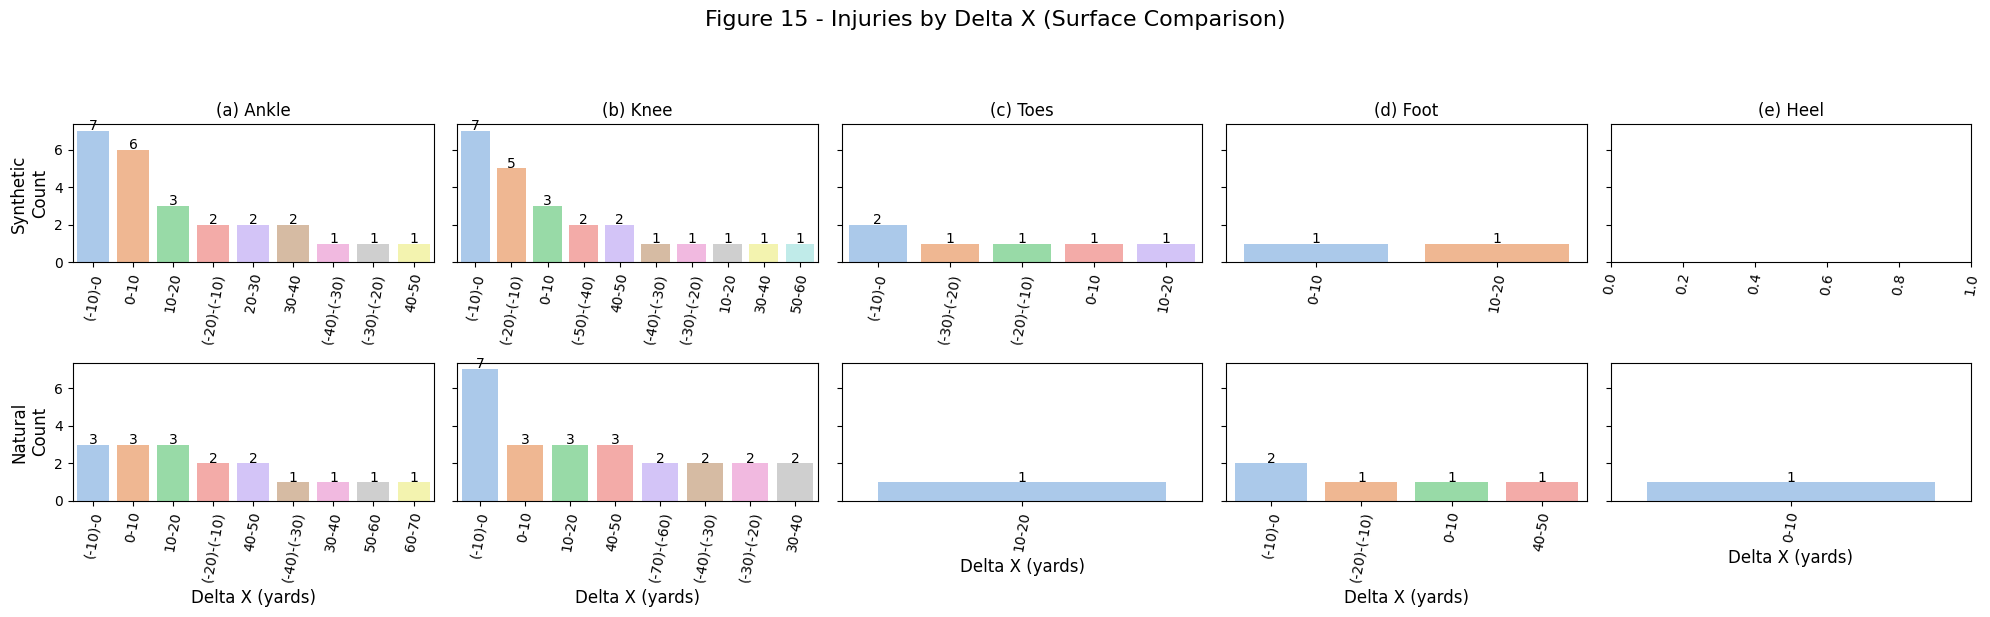

In [29]:
# Define delta_x bins and labels  
delta_x_bins = [-float("inf"), -70, -60, -50, -40, -30, -20 ,-10, 0, 10, 20, 30, 40, 50, 60, 70, float("inf")]  
delta_x_labels = ['<(-70)', '(-70)-(-60)', '(-60)-(-50)', '(-50)-(-40)', '(-40)-(-30)', '(-30)-(-20)', '(-20)-(-10)', '(-10)-0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']  

# Add delta_x column with bins  
inj_track['delta_x_binned'] = pd.cut(inj_track['delta_x'],  
                        bins=delta_x_bins,  
                        labels=delta_x_labels,  
                        include_lowest=True)  

# Define feature parameters for delta_x  
feature = "delta_x_binned"  
feature_filter = "BodyPart"  
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]  
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]  
surface_types = ["Synthetic", "Natural"] 

# Create subplots with 2 rows and 5 columns    
fig, axes = plt.subplots(2, 5, figsize=(20, 6), sharex=False, sharey=True)  

# Loop through each surface type (rows) and each body part (columns)  
for row, surface in enumerate(surface_types):  
    for col, (body_part, title) in enumerate(zip(feature_values, subplot_titles)):  
        ax = axes[row, col]  
        
        # Filter data for the given surface type and body part  
        df_filtered = inj_track[(inj_track['Surface'] == surface) &   
                                (inj_track[feature_filter] == body_part)]  
        
        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  

        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, "Count"]  

        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df["Count"].tolist(),  
            hue=plot_df[feature].tolist(),  
            dodge=False,   
            legend=False,   
            palette="pastel",  
            ax=ax  
        )  

        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(title, fontsize=12)  
        if col == 0:  
            ax.set_ylabel(surface + "\nCount", fontsize=12)  
        else:  
            ax.set_ylabel("")  

        # Only label the x-axis for lower row plots  
        if row == 1:  
            ax.set_xlabel("Delta X (yards)", fontsize=12)  
        else:  
            ax.set_xlabel("")  

        ax.tick_params(axis="x", rotation=80)  

        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
            ax.text(i, row_data["Count"] + 0.01 * row_data["Count"], int(row_data["Count"]),  
                    color='black', ha='center', fontsize=10)  
        
        ax.legend([], [], frameon=False)  

plt.suptitle("Figure 15 - Injuries by Delta X (Surface Comparison)", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()    

### Figure 15 - Insights
- The highest concentration of injuries occurs in the -10 to 10 yard range, suggesting that even relatively small lateral movements carry significant injury risk.
- Knee injuries show the widest distribution across delta X ranges, from -70 to +50 yards, with a notable cluster of 14 injuries in the -10 to 0 yard range, indicating that knee injuries can occur during both short and long-distance lateral movements.
- Ankle injuries demonstrate a more balanced distribution between forward and backward movements, with 42 total injuries spread across multiple ranges.
- Toes, foot, and heel injuries predominantly occur within shorter movement ranges (-20 to +20 yards), with very few cases in extreme ranges, indicating these injuries are more common during controlled, shorter-distance movements rather than explosive lateral transitions.
- Synthetic turf shows a stronger clustering of ankle displacements around the −10 to 0 and 0−10 yard bins, while natural turf displays a slightly broader spread.
-Although both surfaces peak around -10 to 0 yards, synthetic turf has additional knee cases in both high negative and positive ranges, indicating more varied knee movements.

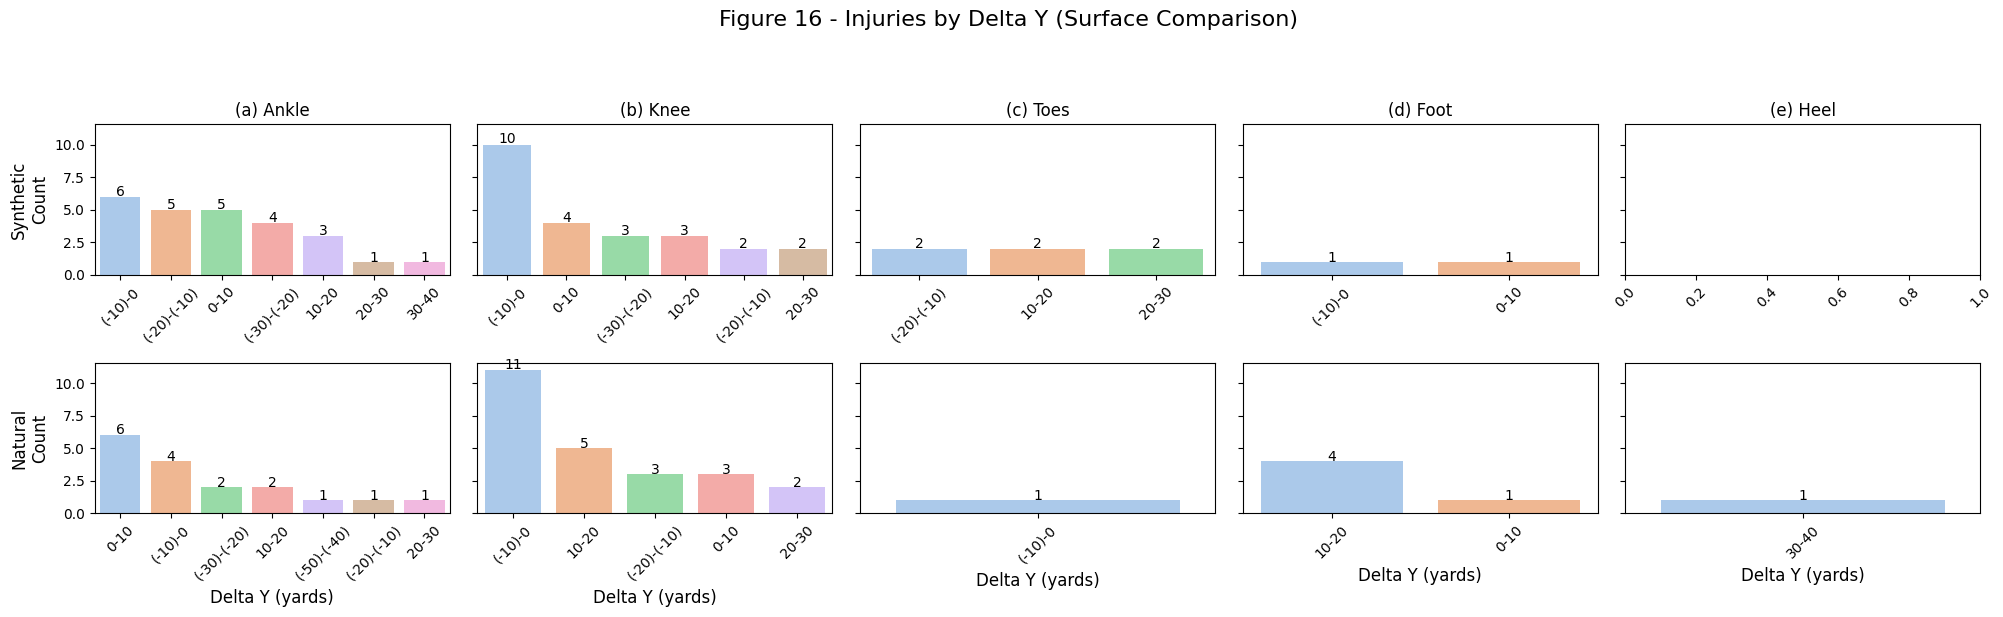

In [30]:
# Define delta_y bins and labels    
delta_y_bins = [-float("inf"), -70, -60, -50, -40, -30, -20 ,-10, 0, 10, 20, 30, 40, 50, 60, 70, float("inf")]    
delta_y_labels = ['<(-70)', '(-70)-(-60)', '(-60)-(-50)', '(-50)-(-40)', '(-40)-(-30)', '(-30)-(-20)', '(-20)-(-10)', '(-10)-0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']    

# Add delta_y column with bins    
inj_track['delta_y_binned'] = pd.cut(inj_track['delta_y'],    
                        bins=delta_y_bins,    
                        labels=delta_y_labels,    
                        include_lowest=True)    

# Define feature parameters for delta_y    
feature = "delta_y_binned"    
feature_filter = "BodyPart"    
feature_values = ["Ankle", "Knee", "Toes", "Foot", "Heel"]    
subplot_titles = ["(a) Ankle", "(b) Knee", "(c) Toes", "(d) Foot", "(e) Heel"]    
surface_types = ["Synthetic", "Natural"]  

# Create subplots with 2 row and 5 columns      
fig, axes = plt.subplots(2, 5, figsize=(20, 6), sharex=False, sharey=True)    

# Loop through each surface type (rows) and each body part (columns)  
for row, surface in enumerate(surface_types):  
    for col, (body_part, title) in enumerate(zip(feature_values, subplot_titles)):  
        ax = axes[row, col]  
        
        # Filter data for the given surface type and body part  
        df_filtered = inj_track[(inj_track['Surface'] == surface) &   
                                (inj_track[feature_filter] == body_part)]  
        
        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  
        
        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, "Count"]  
        
        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df["Count"].tolist(),  
            hue=plot_df[feature].tolist(),  
            dodge=False,  
            legend=False,  
            palette="pastel",  
            ax=ax  
        )  
        
        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(title, fontsize=12)  
        if col == 0:  
            ax.set_ylabel(surface + "\nCount", fontsize=12)  
        else:  
            ax.set_ylabel("")  
        
        # Only label the x-axis for lower row plots  
        if row == 1:  
            ax.set_xlabel("Delta Y (yards)", fontsize=12)  
        else:  
            ax.set_xlabel("")  
        
        ax.tick_params(axis="x", rotation=45)  
        
        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
            ax.text(i, row_data["Count"] + 0.01 * row_data["Count"], int(row_data["Count"]),  
                color='black', ha='center', fontsize=10)  
        
        ax.legend([], [], frameon=False)  

plt.suptitle("Figure 16 - Injuries by Delta Y (Surface Comparison)", fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 16 - Insights
- Most injuries occur with relatively small delta Y values (-10 to +10 yards), suggesting that many injuries happen during plays with minimal sideline-to-sideline movement
- Knee injuries show a strong tendency toward small negative delta Y values (21 cases in -10 to 0), while ankle injuries are more evenly distributed
- Fewer injuries occur during extensive lateral movements (delta Y > ±30 yards), suggesting that plays requiring significant sideline-to-sideline transitions aren't necessarily higher risk; instead, the short, quick lateral shifts appear more associated with injury events.
- Synthetic turf shows more negative vertical displacements for ankles (15 cases in negative ranges vs. 10 in positive), while natural turf demonstrates a slight preference for positive movements (9 cases in positive ranges vs. 8 in negative).
- Both surfaces show similar knee movement patterns with strong clustering around -10 to 0 yards, but natural turf exhibits more cases in the positive direction.
- Natural turf induces more upward foot movements (4 cases in 10-20 range) compared to synthetic's balanced distribution.

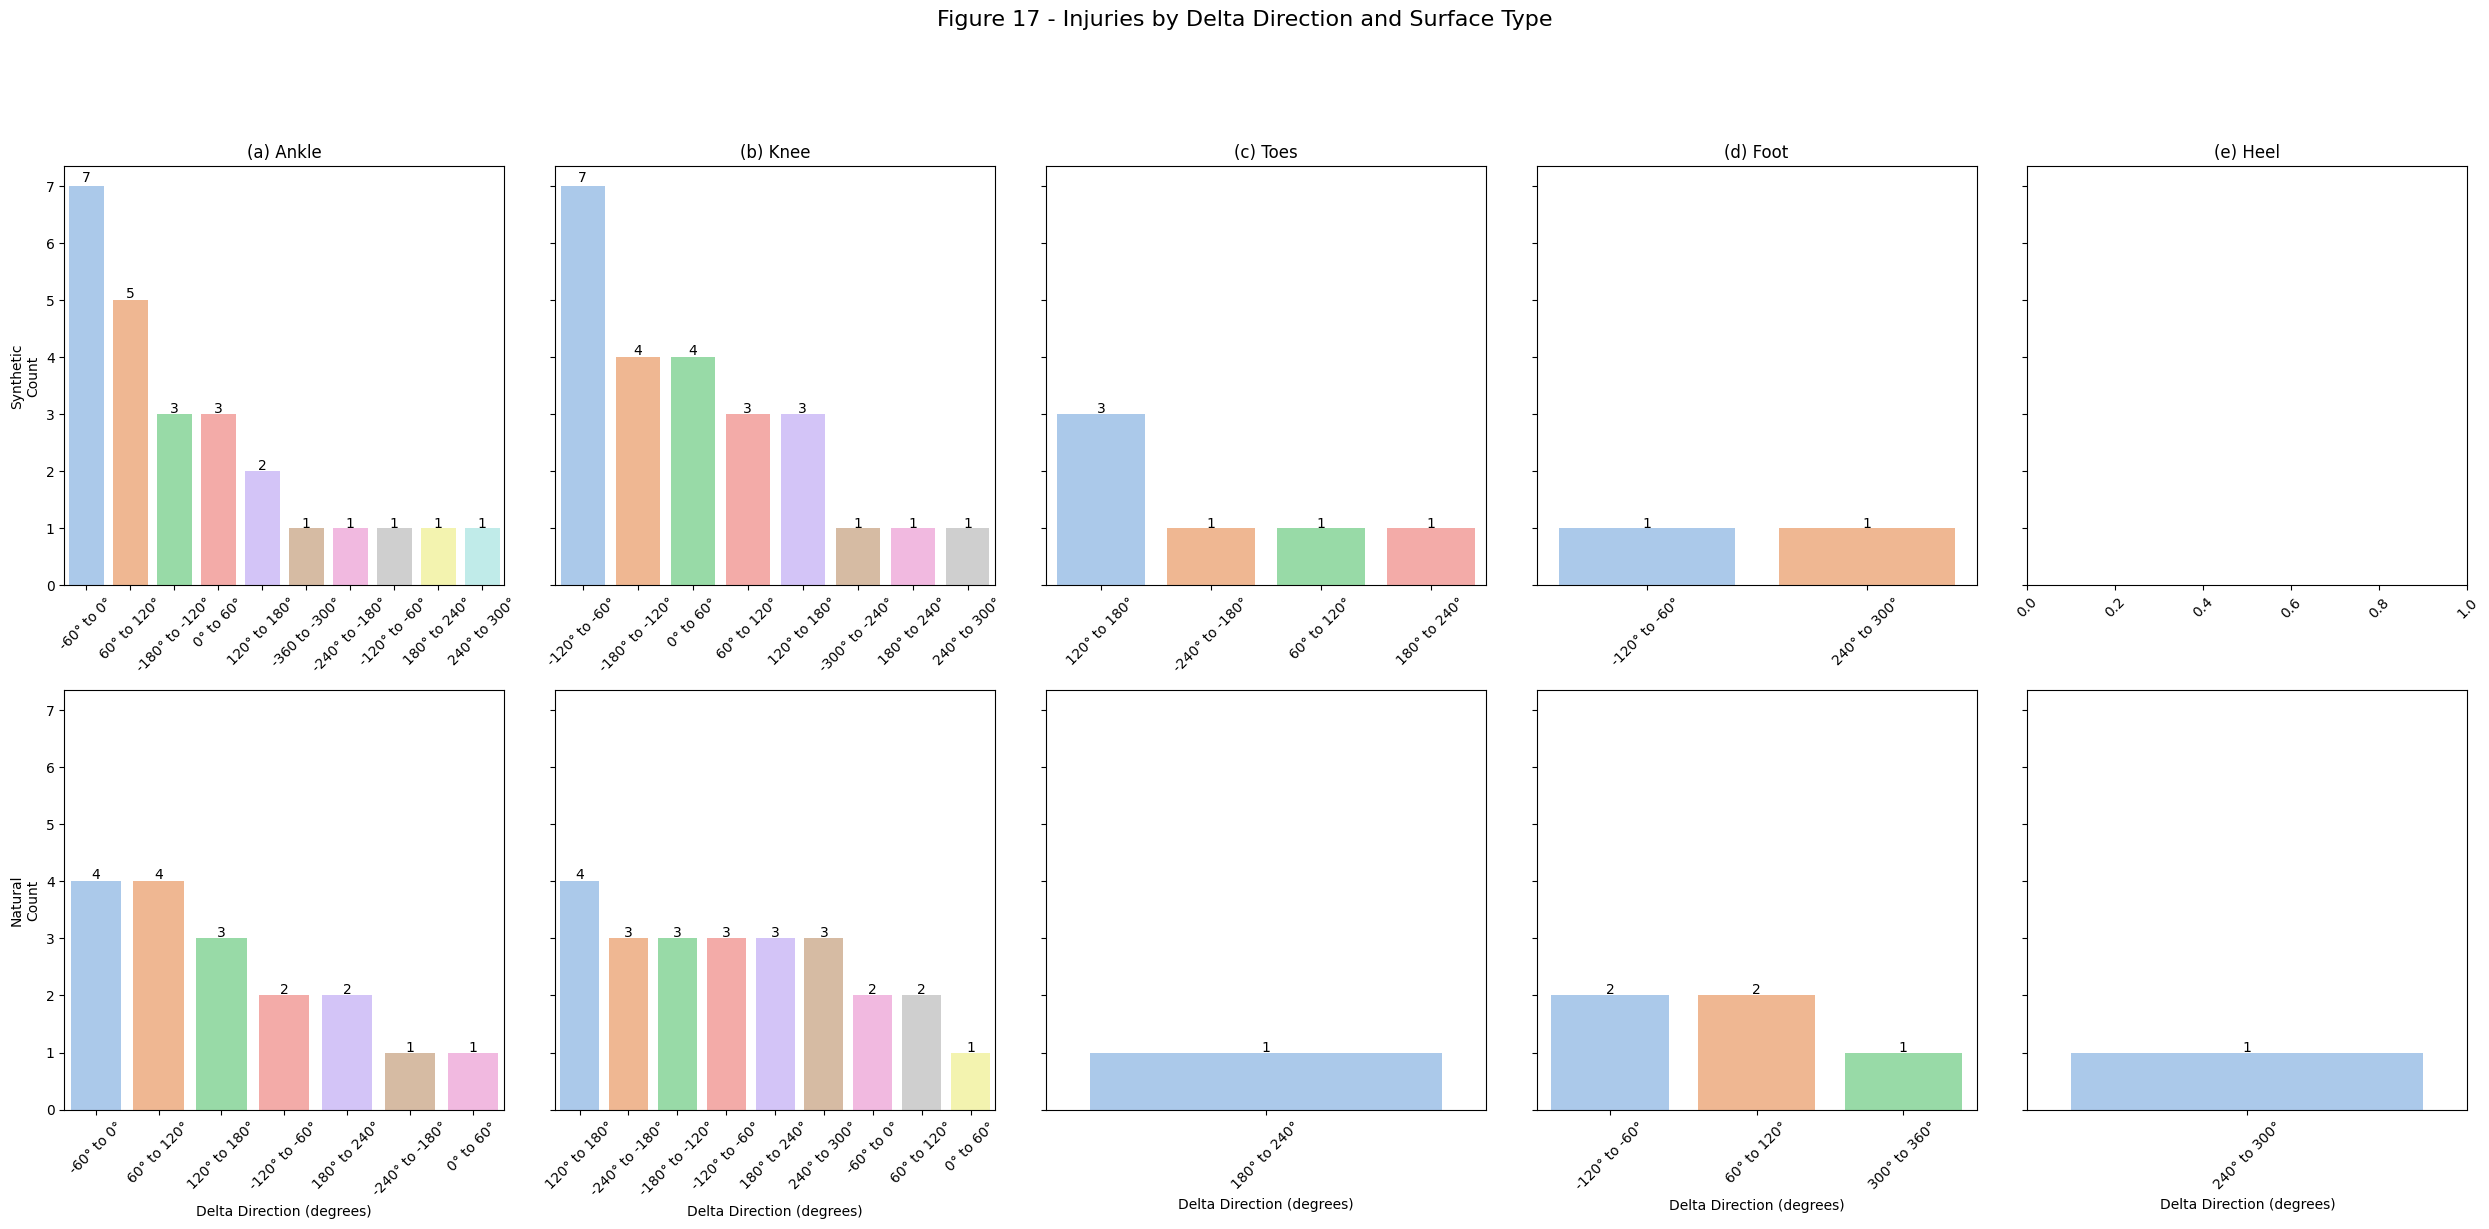

In [31]:
# Define delta_dir bins and labels (in degrees)
# Adjust these bins based on the observed range
delta_dir_bins = [-float("inf"), -360, -300, -240, -180, -120, -60, 0, 60, 120, 180, 240, 300, 360, float("inf")]  
delta_dir_labels = ['<-360°', '-360 to -300°', '-300° to -240°', '-240° to -180°', '-180° to -120°', '-120° to -60°', '-60° to 0°', '0° to 60°', '60° to 120°', '120° to 180°', '180° to 240°', '240° to 300°', '300° to 360°', '>360°']  

# Bin the delta_dir column using pd.cut  
inj_track['delta_dir_binned'] = pd.cut(inj_track['delta_dir'],  
                                        bins=delta_dir_bins,  
                                        labels=delta_dir_labels,  
                                        include_lowest=True)  

# Define feature parameters  
feature = 'delta_dir_binned'  
feature_filter = 'BodyPart'  
feature_values = ['Ankle', 'Knee', 'Toes', 'Foot', 'Heel']  
surface_types = ['Synthetic', 'Natural']  # Assuming these are the values in your surface type column  

# Create subplots with 2 rows (surface types) and 5 columns (body parts)  
fig, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=False, sharey=True)  

# Loop through surface types (rows)  
for row, surface in enumerate(surface_types):  
    # Loop through body parts (columns)  
    for col, body_part in enumerate(feature_values):  
        ax = axes[row, col]  

        # Filter data for the given surface type and body part  
        df_filtered = inj_track[  
            (inj_track['Surface'] == surface) &   
            (inj_track[feature_filter] == body_part)  
        ]  
        
        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  
        
        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, 'Count']  
    
        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df['Count'].tolist(),  
            hue=plot_df[feature].tolist(),  
            dodge=False,  
            palette='pastel',  
            legend=False,  
            ax=ax  
        )  
        
        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(f'({"abcde"[col]}) {body_part}')  
        if col == 0:  
            ax.set_ylabel(f'{surface}\nCount')  
        else:  
            ax.set_ylabel('')  
        
        if row == 1:  # Only show x-labels for bottom row  
            ax.set_xlabel('Delta Direction (degrees)')  
        else:  
            ax.set_xlabel('')  
            
        ax.tick_params(axis='x', rotation=45)  
        
        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
            ax.text(i, row_data['Count'] + 0.01 * row_data['Count'],   
                    int(row_data['Count']),  
                    ha='center', color='black', fontsize=10)  

        ax.legend([], [], frameon=False)  

plt.suptitle('Figure 17 - Injuries by Delta Direction and Surface Type', fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 17 - Insights
- The high concentration of knee and ankle injuries during moderate to sharp direction changes (-120° to +120°) suggests offensive coordinators might reduce injury risk by designing routes with more gradual cuts rather than sharp breaks. For example, running more curved routes instead of hard 90-degree cuts could potentially reduce lower extremity stress.
- Knee injuries show clustering in extreme directional changes (-120° to -60°: 10 cases; -180° to -120°: 7 cases; 120° to 180°: 7 cases), indicating that sharp turns and sudden reversals of direction—common in defensive backpedaling and offensive route breaks—may particularly stress the knee joint.
- The concentration of foot injuries in specific ranges (-120° to -60°: 3 cases) and toe injuries in the forward direction changes (120° to 240°: 5 cases) suggests that different playing positions and movements (such as receivers making breaks or defensive players changing direction) may expose specific parts of the foot to different directional stresses.
- Synthetic turf shows strong clustering in negative angles (-60 to 0 degrees, 7 cases) with scattered distribution across the full circle for ankle injuries, while natural turf demonstrates more balanced clustering between negative and positive angles with fewer extreme angles.
- Synthetic surfaces concentrate knee movements in the -120 to -60 degree range (7 cases), whereas natural turf shows remarkably even distribution across multiple 60-degree intervals with slightly higher frequency in positive angles (120-300 degrees).
- Natural turf induces more varied foot directional changes (clustering in both -120 to -60 and 60-120 degrees) compared to synthetic's sparse distribution.

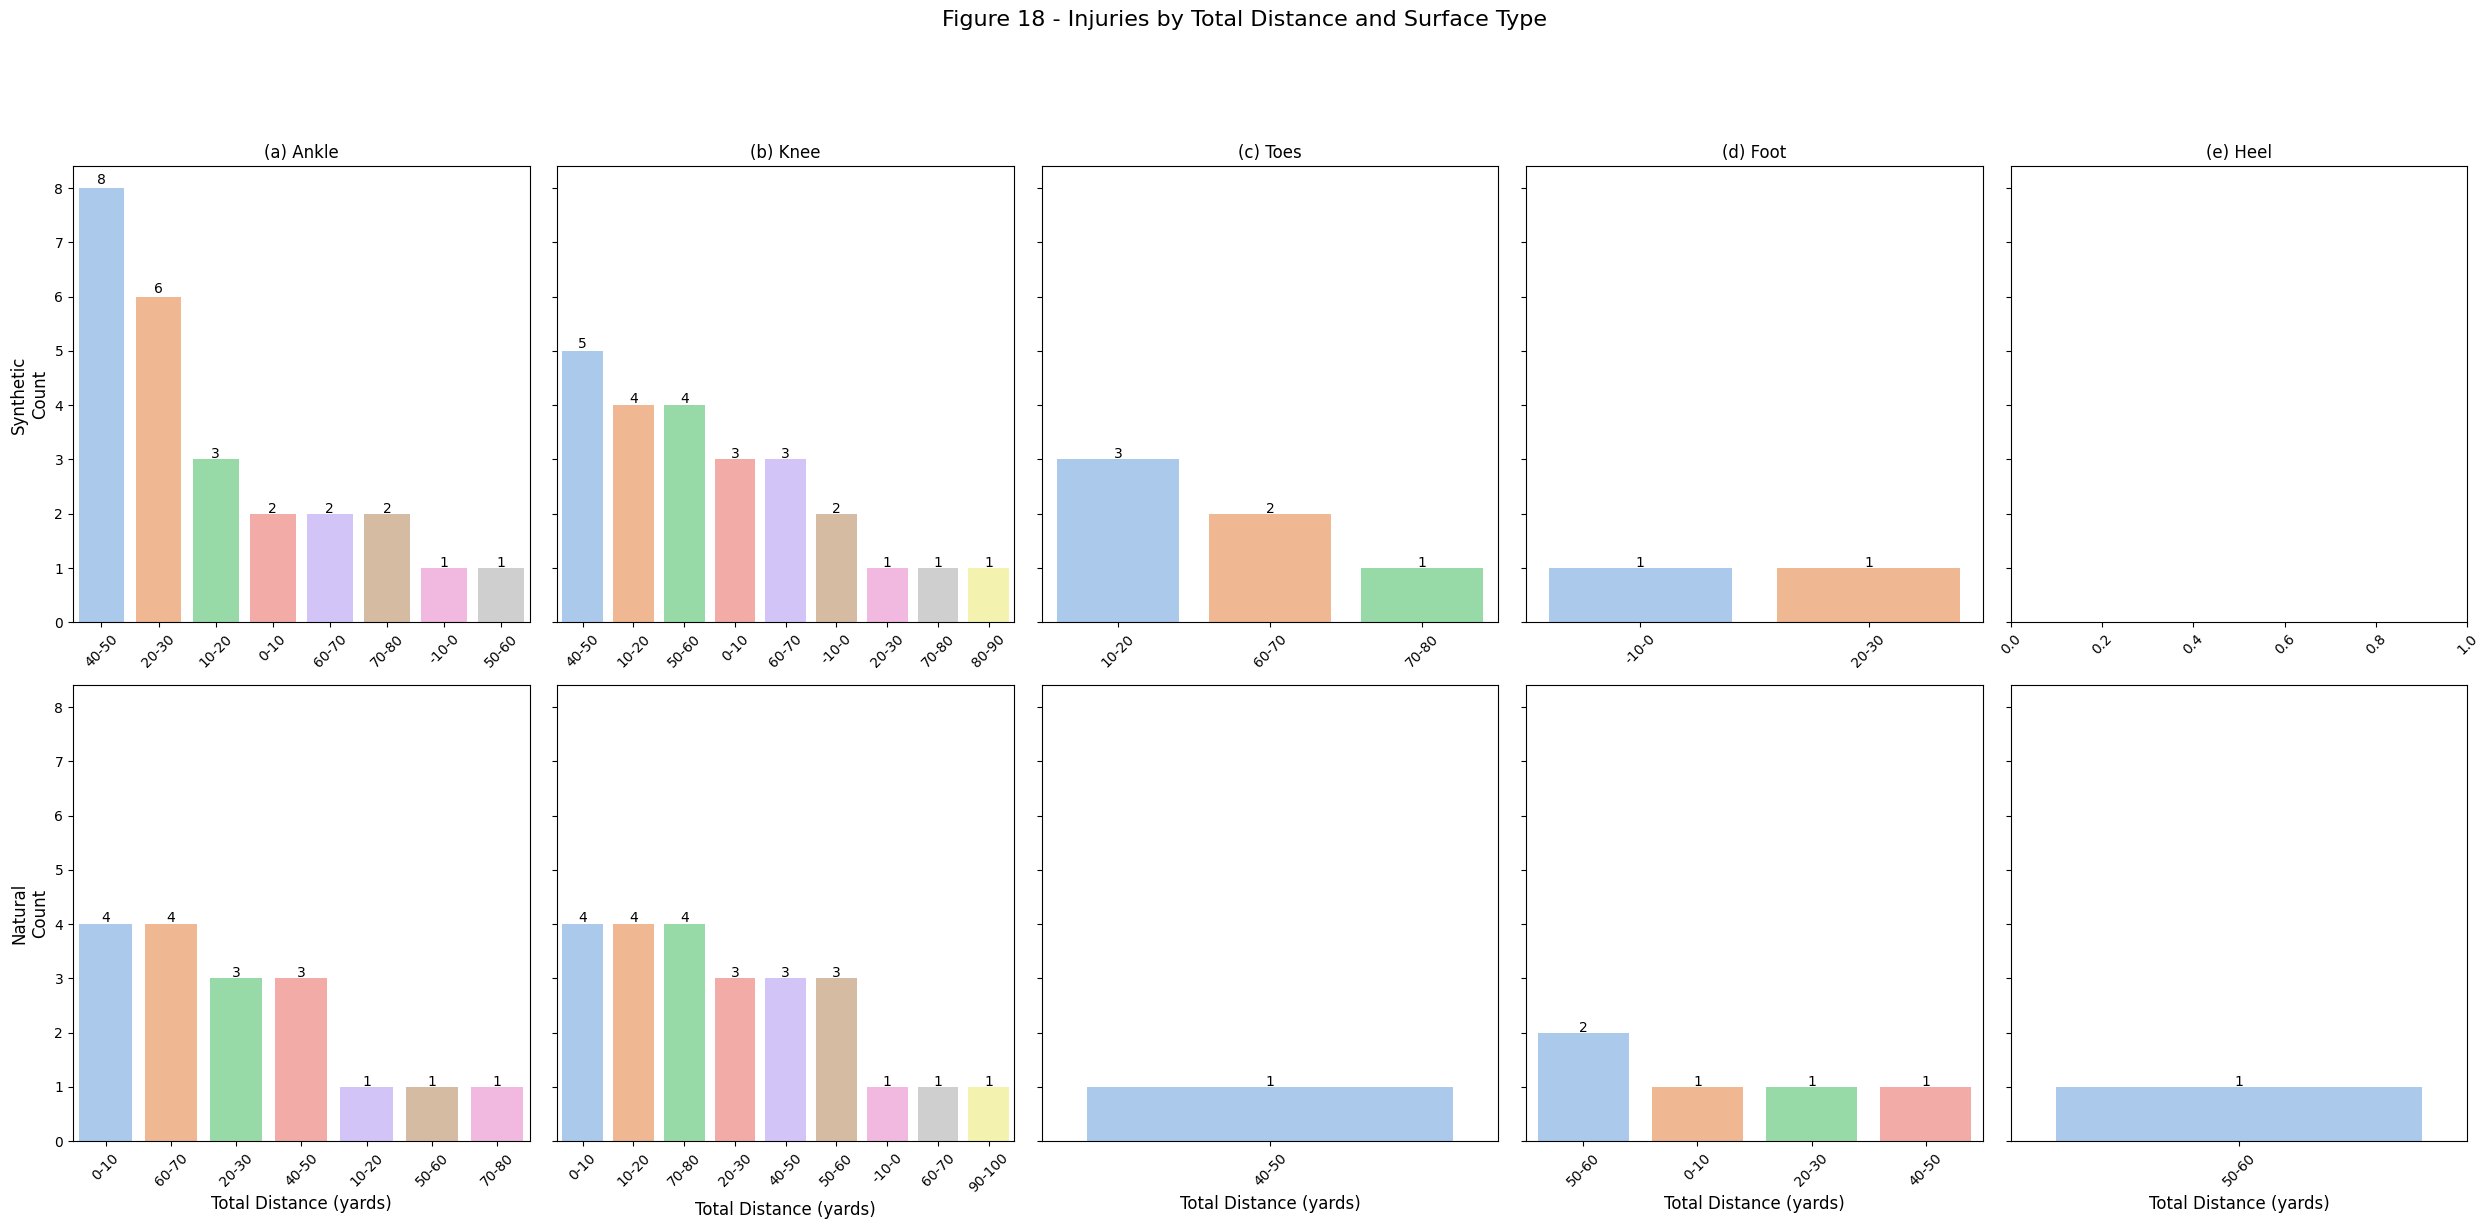

In [32]:
# Define total distance bins and labels (in yards)  
# We'll create bins based on the actual range of the data  
total_distance_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
total_distance_labels = ['-10-0' ,'0-10', '10-20', '20-30', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']  

# Bin the delta_dir column using pd.cut  
inj_track['total_distance_binned'] = pd.cut(inj_track['total_distance'],  
                                        bins=total_distance_bins,  
                                        labels=total_distance_labels,  
                                        include_lowest=True)  

# Define feature parameters  
feature = 'total_distance_binned'  
feature_filter = 'BodyPart'  
feature_values = ['Ankle', 'Knee', 'Toes', 'Foot', 'Heel']  
surface_types = ['Synthetic', 'Natural']  

# Create subplots with 2 rows (surface types) and 5 columns (body parts)  
fig, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=False, sharey=True)  

# Loop through surface types (rows)  
for row, surface in enumerate(surface_types):  
    # Loop through body parts (columns)  
    for col, body_part in enumerate(feature_values):  
        ax = axes[row, col]  

        # Filter data for the given surface type and body part  
        df_filtered = inj_track[  
            (inj_track['Surface'] == surface) &  
            (inj_track[feature_filter] == body_part)  
        ]  

        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  

        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, 'Count']  

        # Sort the DataFrame by the bin ranges  
        #plot_df[feature] = pd.Categorical(plot_df[feature], categories=total_distance_labels, ordered=True)  
        #plot_df = plot_df.sort_values(feature)  

        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df['Count'].tolist(),  
            hue=plot_df[feature].tolist(),  
            palette='pastel',  
            dodge=False,  
            legend=False,  
            ax=ax  
        )  

        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(f'({"abcde"[col]}) {body_part}', fontsize=12)  
        if col == 0:  
            ax.set_ylabel(f'{surface}\nCount', fontsize=12)  
        else:  
            ax.set_ylabel('')  

        if row == 1:  # Only show x-labels for bottom row  
            ax.set_xlabel('Total Distance (yards)', fontsize=12)  
        else:  
            ax.set_xlabel('')  

        ax.tick_params(axis='x', rotation=45)  

        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
            ax.text(i, row_data['Count'] + 0.01 * row_data['Count'],  
                    int(row_data['Count']),  
                    ha='center', color='black', fontsize=10)  

        ax.legend([], [], frameon=False)  

plt.suptitle('Figure 18 - Injuries by Total Distance and Surface Type', fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 18 - Insights
- For ankle injuries on synthetic surfaces, there is a clear concentration with 8 incidents in the 40–50-yard range, indicating that the majority of synthetic ankle injuries occur when players are covering higher distances during plays.
- Natural surface ankle injuries show a more varied distribution, with moderate frequencies in the lower (0–10 yards) and mid-range distances (20–30 and 40–50 yards), suggesting that these injuries may result from a broader range of movement scenarios.
- Knee injuries on synthetic fields peak at 40–50 yards (with 5 incidents) and also show significant occurrences in the 10–20 and 50–60 yard bins, indicating that these injuries are common in plays involving both shorter and longer movement segments.
- On natural surfaces, knee injuries are notably frequent in the lower distance ranges (0–10 and 10–20 yards) and also show a spike in the 70–80-yard bin, implying different movement patterns or stress factors compared to synthetic fields.
- Injuries to the Toes are relatively infrequent, with synthetic surfaces accounting for a few cases mostly in the 10–20 and 60–70-yard ranges, while natural surfaces report only a single case in the 40–50-yard bin.
- Foot and heel injuries are rare overall; synthetic surfaces show minimal foot injuries (only one each in the 20–30 and –10 to 0 bins), while natural surfaces record a slightly higher count for foot injuries and the only occurrence of a heel injury in the 50–60-yard range, highlighting that these injuries might be less dependent on total distance covered.

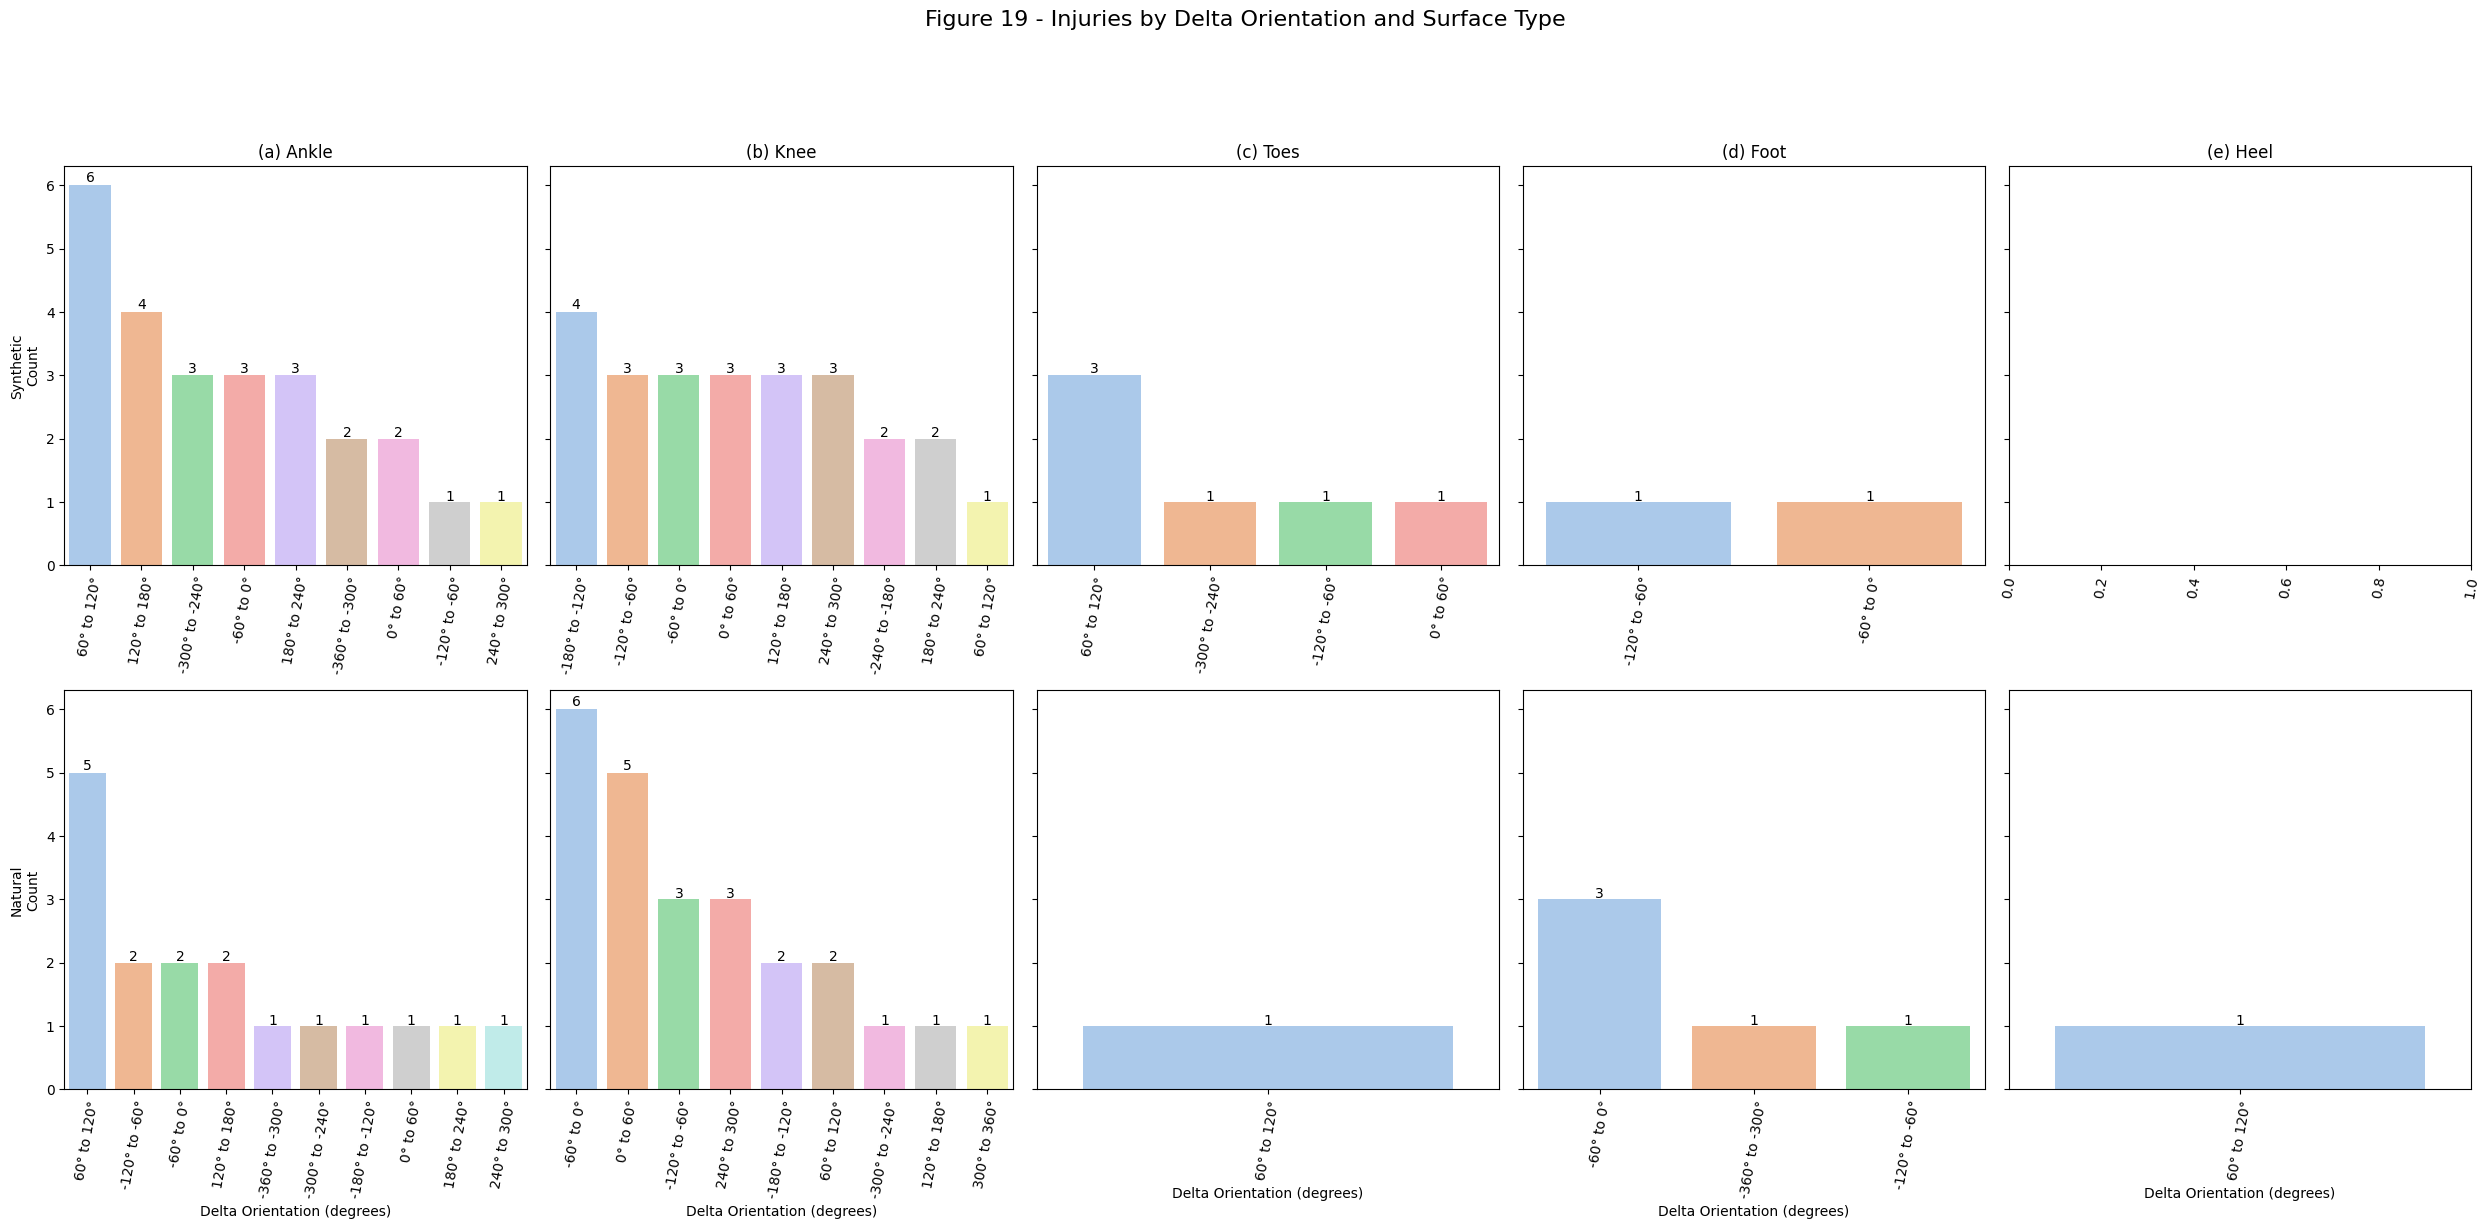

In [33]:
# Define delta_orientation bins and labels (in degrees)  
# Adjust these bins based on the observed range  
delta_orientation_bins = [-float("inf"), -360, -300, -240, -180, -120, -60, 0, 60, 120, 180, 240, 300, 360, float("inf")]  
delta_orientation_labels = ['<-360°', '-360° to -300°', '-300° to -240°', '-240° to -180°', '-180° to -120°', '-120° to -60°', '-60° to 0°', '0° to 60°', '60° to 120°', '120° to 180°', '180° to 240°', '240° to 300°', '300° to 360°', '>360°']  

# Bin the delta_orientation column using pd.cut  
inj_track['delta_orientation_binned'] = pd.cut(inj_track['delta_orientation'],  
                                            bins=delta_orientation_bins,  
                                            labels=delta_orientation_labels,  
                                            include_lowest=True)  

# Define feature parameters  
feature = 'delta_orientation_binned'  
feature_filter = 'BodyPart'   
feature_values = ['Ankle', 'Knee', 'Toes', 'Foot', 'Heel']  
surface_types = ['Synthetic', 'Natural']  

# Create subplots with 2 rows (surface types) and 5 columns (body parts)  
fig, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=False, sharey=True)  

# Loop through surface types (rows)  
for row, surface in enumerate(surface_types):  
    # Loop through body parts (columns)  
    for col, body_part in enumerate(feature_values):  
        ax = axes[row, col]  

        # Filter data for the given surface type and body part  
        df_filtered = inj_track[  
            (inj_track['Surface'] == surface) &  
            (inj_track[feature_filter] == body_part)  
        ]  

        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  

        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, 'Count']  

        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df['Count'].tolist(),  
            hue=plot_df[feature].tolist(),  
            dodge=False,  
            palette='pastel',  
            legend=False,  
            ax=ax  
        )  

        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title(f'({"abcde"[col]}) {body_part}')  
        if col == 0:  
            ax.set_ylabel(f'{surface}\nCount')  
        else:  
            ax.set_ylabel('')  

        if row == 1:  # Only show x-labels for bottom row  
            ax.set_xlabel('Delta Orientation (degrees)')  
        else:  
            ax.set_xlabel('')  

        ax.tick_params(axis='x', rotation=80)  

        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
             ax.text(i, row_data['Count'] + 0.01 * row_data['Count'],  
                    int(row_data['Count']),  
                    ha='center', color='black', fontsize=10)  

        ax.legend([], [], frameon=False)  

plt.suptitle('Figure 19 - Injuries by Delta Orientation and Surface Type', fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 19 - Insights
- Ankle injuries most commonly occur during moderate turns (60-120 degrees) on both surface types, with 6 cases on synthetic and 5 on natural turf. This suggests that quick turning movements in this range are risky for ankles regardless of what surface players are on.
- Knee injuries tell a different story between surfaces: on natural grass, most injuries happen during small turns (-60 to +60 degrees, with 11 total cases), while on synthetic turf, the injuries are more evenly spread across different turning angles. This hints that the surface type affects how knees get injured during turns.
- Players seem to experience more extreme twisting movements (beyond 180 degrees) leading to ankle injuries on synthetic turf compared to natural grass. This could mean that synthetic surfaces might not allow players' feet to pivot as naturally during sharp turns.
- Foot and toe injuries show an interesting pattern: on synthetic turf, they happen during various types of turns, while on natural grass, they mostly occur during smaller, more controlled movements.
- Most knee and ankle injuries happen during medium-sized turns (60-180 degrees), rather than during very sharp or minimal turns. This is important because it shows that even regular turning movements, not just extreme ones, can lead to injuries.
- Heel injuries are very rare with only one case on natural grass during a moderate turn, and toe injuries are uncommon on both surfaces. This tells us that these types of injuries might have more to do with direct hits or straight-line running than with turning movements.

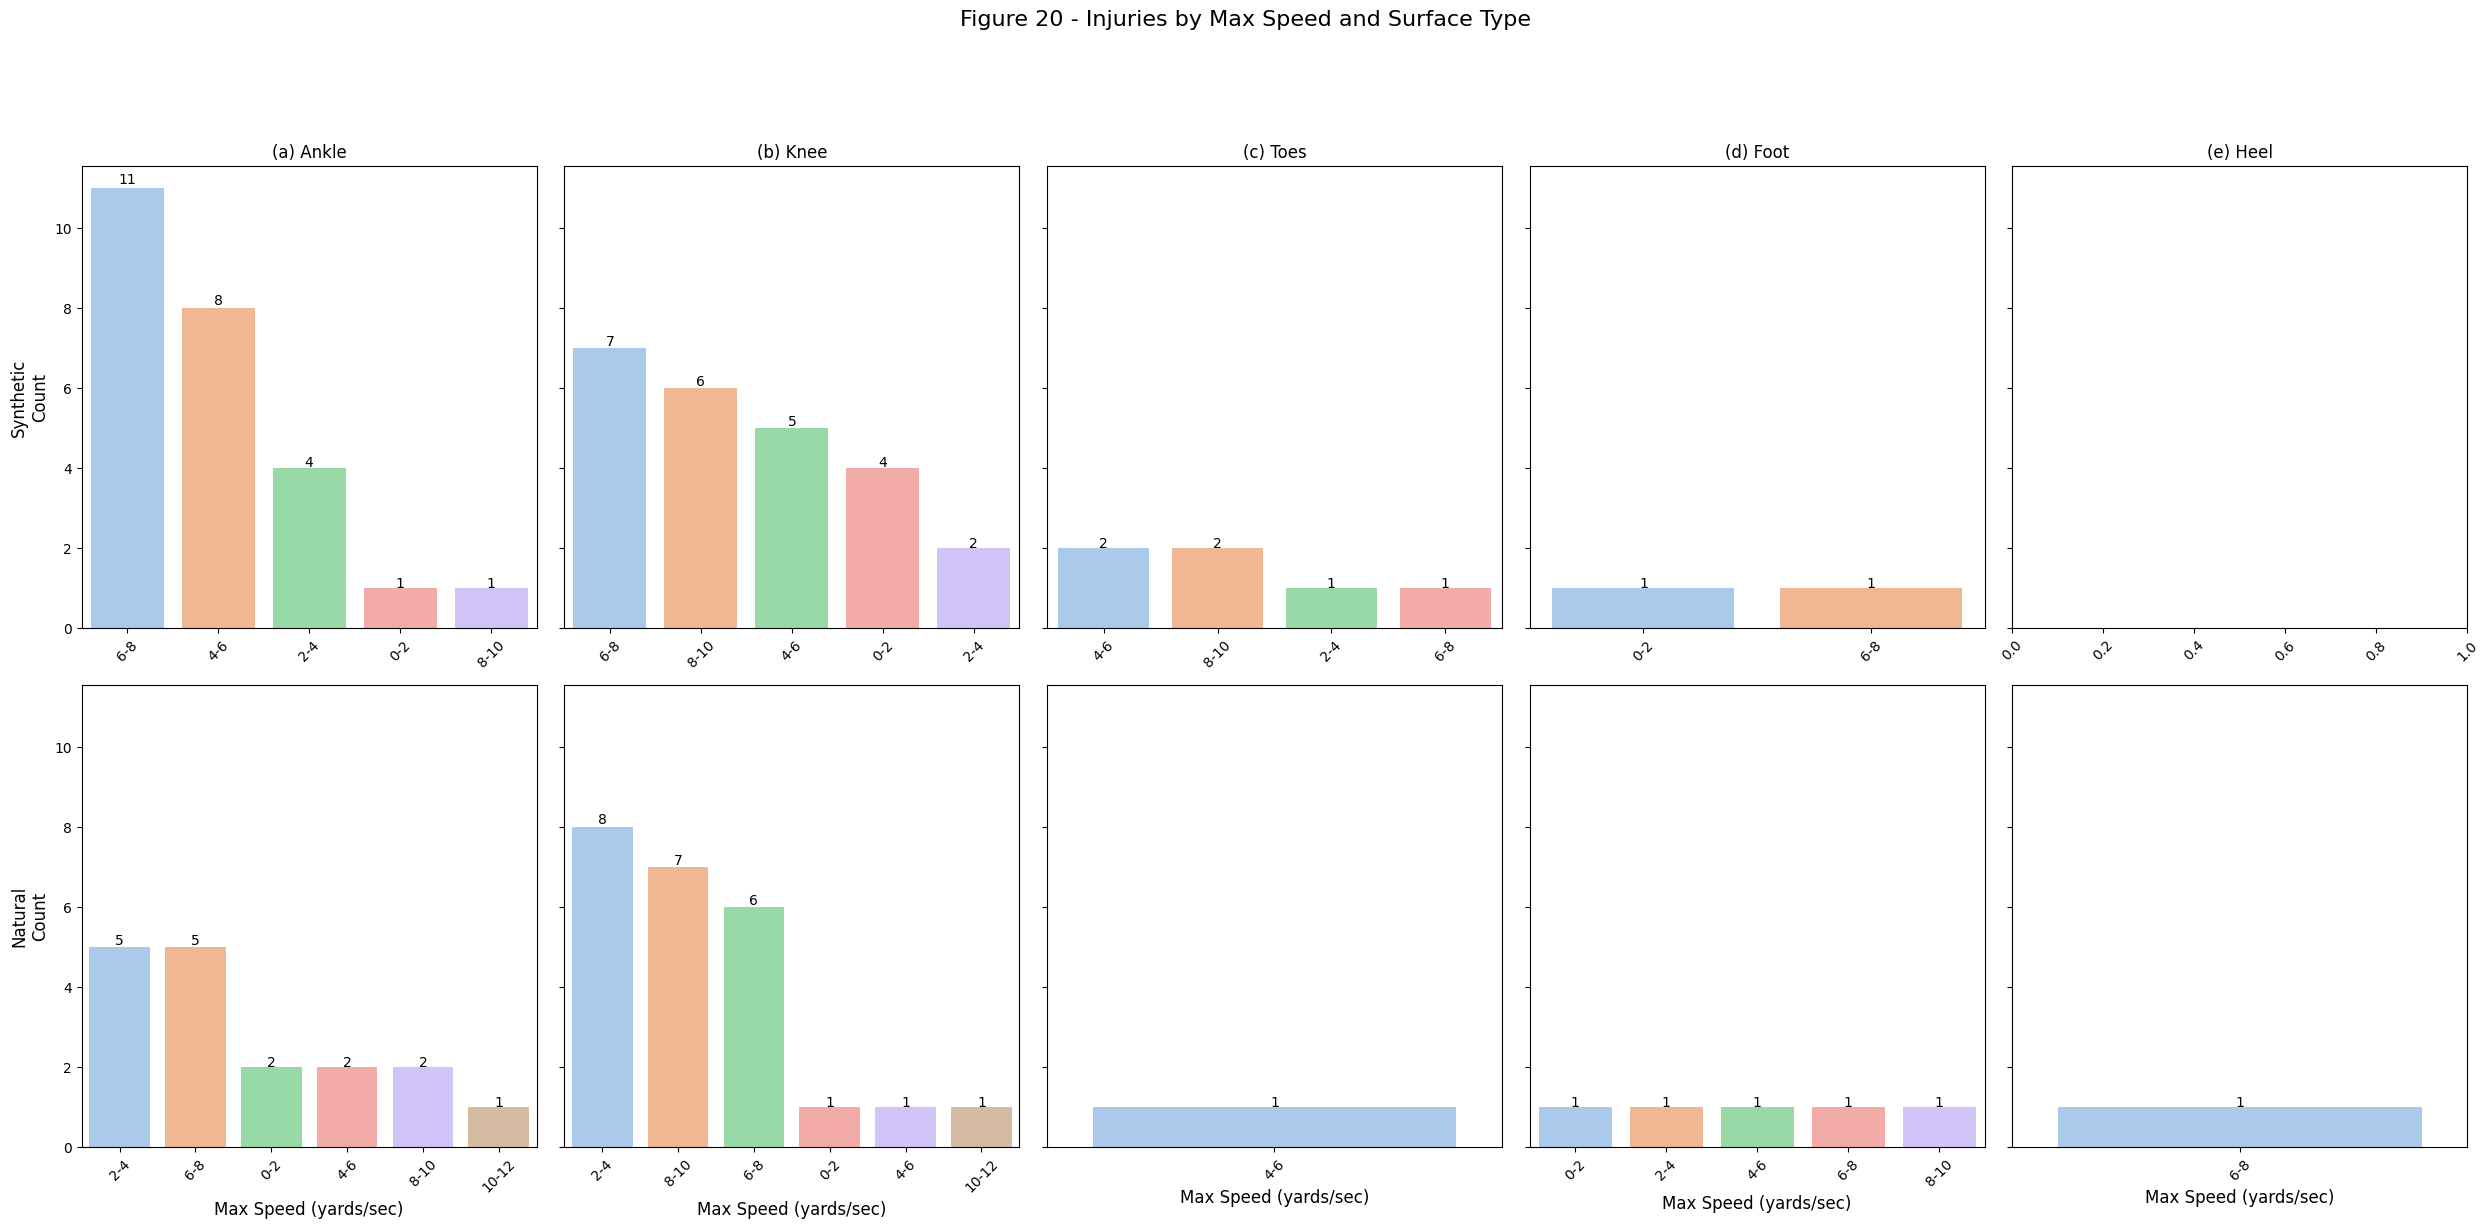

In [34]:
# Define max speed bins and labels 
max_speed_bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]  
max_speed_labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20']

# Bin the max_speed column using pd.cut  
inj_track['max_speed_binned'] = pd.cut(inj_track['max_speed'],  
                                        bins=max_speed_bins,  
                                        labels=max_speed_labels,  
                                        include_lowest=True)  

# Define feature parameters for max speed  
feature = 'max_speed_binned'  
feature_filter = 'BodyPart'  
feature_values = ['Ankle', 'Knee', 'Toes', 'Foot', 'Heel']  
surface_types = ['Synthetic', 'Natural']  

# Create subplots with 2 rows (surface types) and 5 columns (body parts)  
fig, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=False, sharey=True)  

# Loop through surface types (rows)  
for row, surface in enumerate(surface_types):  
    # Loop through body parts (columns)  
    for col, body_part in enumerate(feature_values):  
        ax = axes[row, col]  

        # Filter data for the given surface type and body part  
        df_filtered = inj_track[(inj_track['Surface'] == surface) &  
                            (inj_track[feature_filter] == body_part)]  

        # Compute value counts and filter out bins with zero count  
        counts = df_filtered[feature].value_counts()  
        counts = counts[counts > 0]  

        # Create DataFrame for plotting  
        plot_df = counts.reset_index()  
        plot_df.columns = [feature, 'Count']  

        # Create the bar plot  
        sns.barplot(  
            x=plot_df[feature].tolist(),  
            y=plot_df['Count'].tolist(),  
            hue=plot_df[feature].tolist(),  
            palette='pastel',  
            dodge=False,  
            legend=False,  
            ax=ax  
        )  

        # Set subplot title and axis labels  
        if row == 0:  
            ax.set_title('(' + "abcde"[col] + ') ' + body_part, fontsize=12)  
        if col == 0:  
            ax.set_ylabel(surface + "\nCount", fontsize=12)  
        else:  
            ax.set_ylabel('')  

        if row == 1:  # Only show x-labels for bottom row  
            ax.set_xlabel('Max Speed (yards/sec)', fontsize=12)  
        else:  
            ax.set_xlabel('')  

        ax.tick_params(axis='x', rotation=45)  

        # Annotate each bar with its count value  
        for i, row_data in plot_df.iterrows():  
             ax.text(i, row_data['Count'] + 0.01 * row_data['Count'],  
                    int(row_data['Count']),  
                    ha='center', color='black', fontsize=10)  

        ax.legend([], [], frameon=False)  

plt.suptitle('Figure 20 - Injuries by Max Speed and Surface Type', fontsize=16, y=1.02)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()  

### Figure 20 - Insights
- On synthetic fields, most ankle injuries occur when players reach speeds between 6 and 8 yards per second (11 cases), while on natural fields the distribution is more spread out with a balanced mix in the mid-speed ranges. This pattern suggests that synthetic surfaces may encourage or expose players to higher speeds during turns or maneuvers that strain the ankle.
- For knee injuries, synthetic turf sees a concentration in the mid-speed range (7 cases at 6–8 and 6 cases at 8–10 yards per second), whereas on natural grass the highest frequency is at the lower range (8 cases at 2–4 yards per second). This indicates that different surfaces may affect how fast athletes move when their knees are vulnerable.
- Synthetic turf appears to be associated with higher peak speeds (more injuries at 6–8 and 8–10 yards/sec) for both ankle and knee injuries, suggesting that the surface might allow players to reach higher speeds that potentially increase injury risk.
- Toe injuries are rarer overall, with synthetic turf showing injuries at several speed ranges compared to a single occurrence on natural grass. This may hint that while toe injuries are uncommon, the events leading to them can happen at various speeds.
- Foot injuries on synthetic surfaces occur at the very low (0–2) and at moderate speeds (6–8 yards/sec), while on natural grass, the injuries are more evenly spread across different speed ranges. This points to different movement and impact patterns based on the surface.
- Heel injuries are very infrequent with only one case on natural turf at 6–8 yards per second, suggesting that heel injuries might be more isolated and influenced by factors other than speed.

#### Lets check out the correlation between the movement features and body part.

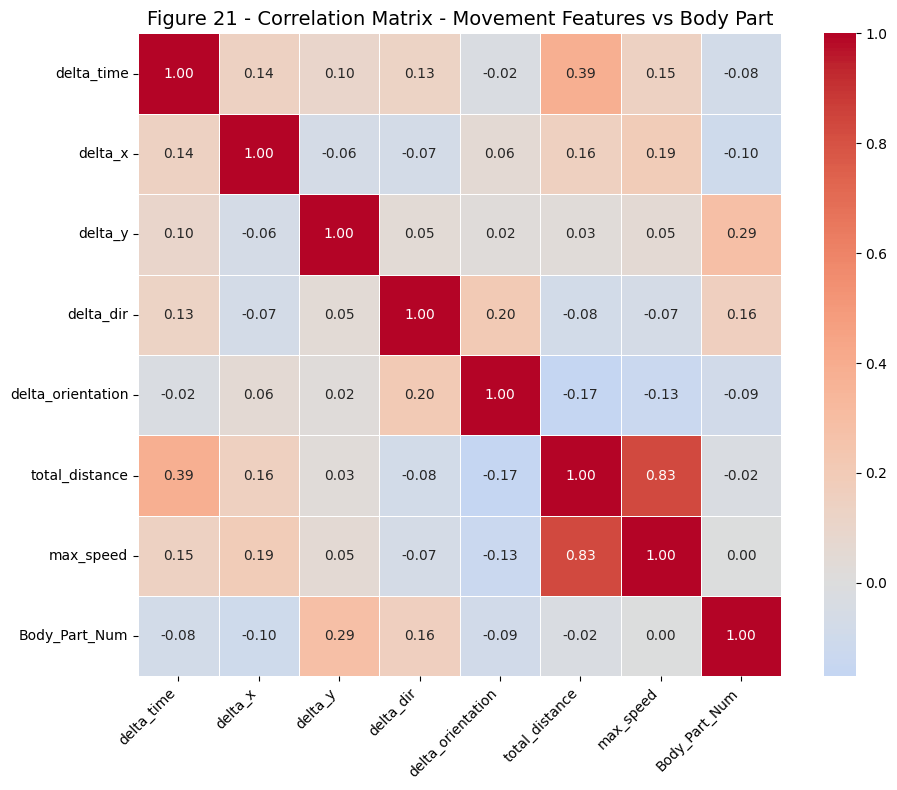

In [35]:
# Create mapping dictionary for body parts  
body_part_dict = {  
    "Ankle": 1,  
    "Knee": 2,  
    "Toes": 3,  
    "Foot": 4,  
    "Heel": 5  
}  

# Create a copy of the dataframe  
df_corr = inj_track.copy()  

# Apply mapping for body part  
df_corr['Body_Part_Num'] = df_corr["BodyPart"].map(body_part_dict)  

# Select features for correlation  
features = ['delta_time', 'delta_x', 'delta_y', 'delta_dir', 'delta_orientation', 'total_distance', 'max_speed', 'Body_Part_Num']  

# Create correlation matrix  
correlation_matrix = df_corr[features].corr()  

# Create heatmap  
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix,  
            annot=True,  
            fmt='.2f',  
            cmap='coolwarm',  
            center=0,  
            square=True,  
            linewidths=.5)  

plt.title("Figure 21 - Correlation Matrix - Movement Features vs Body Part", fontsize=14)  
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()  

### Figure 21 - Insights
- The correlation between delta_time and Body_Part_Num is about -0.08, which is very weak. This suggests that the duration of the play does not have a clear link to which body part gets injured.
- With a correlation of -0.10 between delta_x and Body_Part_Num, changes in the x-direction show a small negative association with the injured body part.
- The delta_y variable has a moderate positive correlation (0.29) with Body_Part_Num, indicating that vertical movement changes might be more related to the type of body part injured – higher values in vertical change seem to be associated with certain injury locations.
- The delta_dir variable has a weak positive correlation (0.16) with Body_Part_Num. This hints that the overall directional change may have a limited role in influencing which body part is injured.
- The delta_orientation shows a very weak negative correlation (-0.09) with Body_Part_Num, implying that the specific rotational change in orientation isn’t strongly linked with injury location.
- Both total_distance and max_speed have near-zero correlations with the Body_Part_Num (around -0.02 and 0.00 respectively), which indicates that the overall distance covered and the maximum speed reached during a play are not directly associated with the particular body part injured.

## Analysis of Lower-Extremity Injuries by Playing Surface

In this section, we will:

- Compare the frequency of lower-extremity injuries (ankle, knee, foot, toes, heel) on synthetic versus natural surfaces.
- Use a chi-square test to examine if the injury frequencies differ significantly between the two surfaces.
- Visualize the injury distributions.
- Provide actionable recommendations for training adjustments and field maintenance practices.

Problem Statement Recap:
Analyze two seasons of NFL player tracking and injury data to compare the frequency of lower-extremity injuries on synthetic versus natural playing surfaces using statistical tests to establish significance and provide actionable recommendations for training adjustments and field maintenance practices, with the objective of reducing injury incidence by the upcoming season.

Injury contingency table:
BodyPart   Ankle  Foot  Heel  Knee  Toes
Surface                                 
Natural       17     5     1    24     1
Synthetic     25     2     0    24     6

Chi-square test results:
Chi2 Statistic: 6.66
Degrees of Freedom: 4
P-value: 0.1551


<Figure size 1000x600 with 0 Axes>

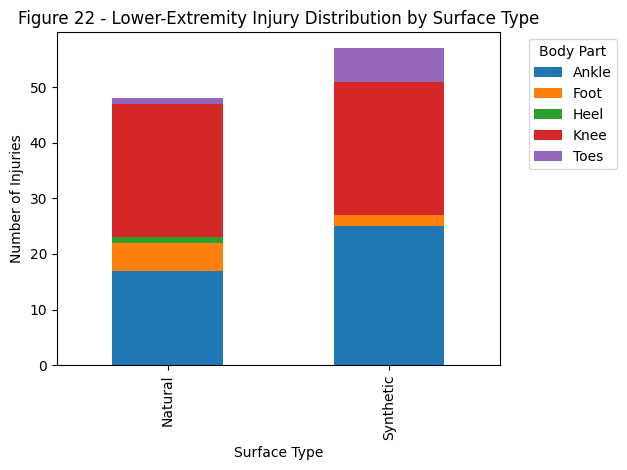

In [36]:
from scipy.stats import chi2_contingency  

# Filter the injury records
injuries = ['Ankle', 'Knee', 'Foot', 'Toes', 'Heel']  
injury_subset = injury_record[injury_record['BodyPart'].isin(injuries)]  

# Create a contingency table: count of injuries by Surface and BodyPart  
injury_contingency = pd.crosstab(injury_subset['Surface'], injury_subset['BodyPart'])  
print("Injury contingency table:")  
print(injury_contingency)  

# Perform Chi-Square test  
chi2, p_value, dof, expected = chi2_contingency(injury_contingency)  
print("\nChi-square test results:")  
print("Chi2 Statistic:", round(chi2, 2))  
print("Degrees of Freedom:", dof)  
print("P-value:", round(p_value, 4))  

# Visualize the injury counts  
plt.figure(figsize=(10, 6))  
injury_contingency.plot(kind='bar', stacked=True, color=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd'])  
plt.title("Figure 22 - Lower-Extremity Injury Distribution by Surface Type")  
plt.xlabel("Surface Type")  
plt.ylabel("Number of Injuries")  
plt.legend(title="Body Part", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()  

### Interpretation of Chi-Square Test and Insights

The chi-square test examined whether there's a significant relationship between the type of surface (Natural vs. Synthetic) and the frequency of injuries to different body parts (Ankle, Foot, Heel, Knee, Toes).

- The Results:
    - Chi2 Statistic: 6.66
        - This is the calculated difference between what we observed and what we would expect if there was no relationship
        - The higher the number, the bigger the difference between observed and expected frequencies
    - Degrees of Freedom: 4
        - This represents the number of independent values that can vary in the analysis
        - Calculated as: (rows-1) × (columns-1) = (2-1) × (5-1) = 1 × 4 = 4
    - P-value: 0.1551
        - This is the key number for interpretation
        - Since 0.1551 > 0.05 (standard significance level), we cannot conclude there is a statistically significant relationship
        - In other words, there isn't strong enough evidence to say that the pattern of injuries differs significantly between natural and synthetic surfaces

What This Means:
- While we see some differences in injury patterns between surfaces (like more ankle injuries on synthetic surfaces), these differences are not statistically significant enough to conclude that the surface type definitively influences the type of injury that occurs. Other factors may be more important in determining injury risk.

### High-Level Actionable Recommendations Based on Project Insights

1. Injury Distribution:
- Knee and ankle injuries dominate, accounting for over 85% of all injuries, with knee injuries being slightly more prevalent on natural surfaces and ankle injuries more common on synthetic surfaces.
- Foot and toe injuries occur less frequently, while heel injuries are very rare.

2. Surface Influence:
- Injury occurrences are relatively balanced between synthetic (53.8%) and natural (46.2%) surfaces.
- Different injury patterns emerge by surface type, suggesting that the playing surface may influence injury type and severity.

3. Movement Dynamics:
- Vertical movement changes (delta_y) show a moderate association with injury location, implying that upward/downward forces may impact which body part is injured.
- Other movement metrics, such as overall speed and distance, have near-zero correlations with the injury site, indicating that the nature of movement (e.g., abrupt direction changes) may be more influential than overall play duration or speed.

4. Actionable Recommendations:
- Targeted Strength and Conditioning Programs:
    - Knee & Ankle Focus: Develop and incorporate specific strength, flexibility, and stability training exercises aimed at reducing knee and ankle injuries.
- Injury Prevention Protocols:
    - Regularly assess and optimize the physical properties of both synthetic and natural fields (e.g., traction, cushioning) to mitigate injury risk.
    - Implement warm-up exercises that emphasize dynamic balance and controlled directional changes, particularly targeting the forces associated with vertical movement.
- Data-Driven Monitoring and Adjustments:
    - Ongoing Analysis: Establish a systematic injury and performance tracking process across seasons to monitor changes and identify trends in injury patterns.
    - Feedback Loop: Use periodic data reviews to adjust training strategies and field maintenance practices, ensuring that interventions remain effective over time.
- Collaborative Interventions:
    - Engage with coaching staff, athletic trainers, and field maintenance teams to integrate these data-driven insights into practice regimens and facility operations.

### End Goal: The aim is to leverage these insights to implement targeted interventions that reduce the incidence of lower-extremity injuries and ultimately lower overall injury rates as the new season approaches.

### THANK YOU!!! 